# Preprocessing

In [1]:

import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "/Users/smgroves/Dropbox (VU Basic Sciences)/pycharm_workspace/mazebox/")
import mazebox as mb


Bad key "text.kerning_factor" on line 4 in
/Users/smgroves/Documents/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
indir = "/Users/smgroves/Documents/pycharm_workspace/archetypes/data/single-cell/looms/RPM"

samples = ['SRR11594447','SRR11594448','SRR11594449','SRR11594450','SRR11594451','SRR11594452']
[a1,a2,a3,a4,a5,a6] = [mb.pp.read_loom(sample, indir) for sample in samples]


## Filter and concatenate

In [ ]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM']


Dropkick is a tool to get rid of empty and low-quality droplets based on ambient reads. It should be applied to each sample separately, so we will apply first and then concantenate the data into one AnnData object.

In [ ]:
batch_categories = ['RPM1','RPM2','RPM3','RPM4']
batch_key = 'tumor'

a3 = a3.concatenate(a4)
a5 = a5.concatenate(a6)
adata = a1.concatenate([a2,a3,a5], batch_key=batch_key, batch_categories=batch_categories)




In [ ]:
adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

## Cell Cycle Regression

In [ ]:
# sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','tumor'])

## Dimensionality Reduction and RNA Velocity

In [ ]:
import matplotlib.pyplot as plt
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata, color = ['tumor','leiden','Ascl1','Chga','Epcam','Hes1'], ncols = 3)


Compare our filtered dataset to the Ireland et al. paper. They have a spreadsheet of the barcodes they kept for downstream analyses.

In [ ]:
bcs = pd.read_csv('../data/RPM_cell_barcodes.csv', index_col=0, header = 0)
bcs['barcode_short'] = [i.split('-')[0] for i in bcs['Tumor Cell Barcodes']]

adata.obs['barcode'] = [str(i.split(":")[1].split('x')[0]) for i in adata.obs_names]

filtered_cells = []
for i in adata.obs['barcode']:
    if i in list(bcs['barcode_short']): 
        filtered_cells.append(True)
    else:
        filtered_cells.append(False)
adata.obs['kept'] = filtered_cells
sc.pl.umap(adata, color = 'kept')

In [ ]:
adata = adata[adata.obs['kept'],:]

In [ ]:
adata.write_h5ad('../int/rpm/adata01_tumors.h5ad')

In [ ]:
adata = sc.read_h5ad('../int/rpm/adata01_tumors.h5ad')

In [ ]:
sc.pp.neighbors(adata, random_state=1) #recalculating after subsetting data and cell cycle correction)
sc.tl.pca(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state=1)
sc.pl.pca(adata, color = 'tumor')
sc.pl.umap(adata, color = ['tumor'])


In [ ]:
scv.pp.moments(adata)
scv.tl.velocity(adata, mode = 'deterministic', groupby='tumor')
scv.tl.velocity_graph(adata)


In [ ]:
sc.tl.tsne(adata, random_state=1)
sc.pl.tsne(adata, color = 'tumor')

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis = 'umap', color = ['Ascl1','Neurod2','Yap1'], figsize = (6,4), alpha=.3, smooth =True)

In [ ]:
scv.tl.velocity_confidence(adata)

keys = 'velocity_length', 'velocity_confidence'  
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], basis = 'umap')

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis = 'umap', figsize = (8,6), legend_loc = 'on right',color = 'tumor')


Let's save the data at this point.

In [ ]:
adata.write_h5ad('../int/rpm/adata02_tumor.h5ad')

In [3]:
adata = sc.read_h5ad('../int/rpm/adata05_tumor.h5ad')

# Signature Subtyping

In [4]:
sig_matrix = pd.read_csv('../data/sig_matrix_ParTI.csv', header =0, index_col = 0)



In [5]:

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
ind = []
for i in sig_matrix.index:
    ind.append(i.capitalize())
sig_matrix.index = ind


In [6]:
adata

AnnData object with n_obs × n_vars = 4786 × 20636
    obs: 'Clusters', '_X', '_Y', 'batch', 'tumor', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'barcode', 'kept', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'ctrp', 'absorbing', 'doublet_scores', 'predicted_doublets'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma_RPM1', 'velocity_r2_RPM1', 'velocity_genes_RPM1', 'velocity_gamma_RPM2', 'velocity_r2_RPM2', 'velocity_genes_RPM2', 'velocity_gamma_RPM3', 'velocity_r2_RPM3', 'velocity_genes_RPM3', 'velocity_gamma_RPM4', 'velocity_r2_RPM4', 'velocity_genes_RPM4'
    uns: 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'phase_colors', 'tumor_colors', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: '

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (95, 5)
Tumor data shortened to genes in gene list...
(4612, 95)
Tumor data subsetting complete.


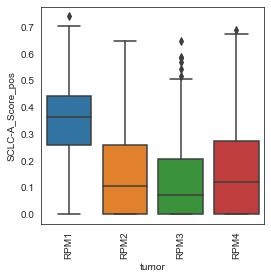

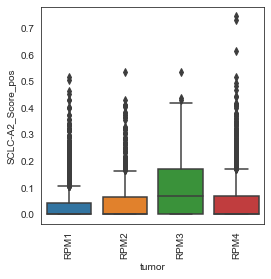

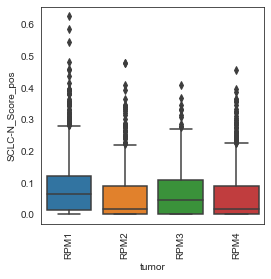

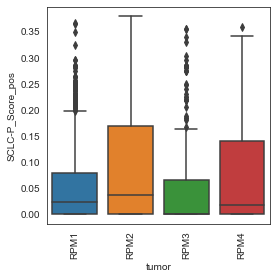

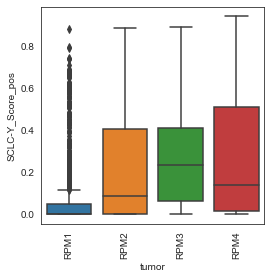

In [7]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'tumor', save_as = 'rpm_tumors', type = 'csr')


In [8]:
phenotype = []

df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]

for i, r in df.iterrows():
    test = r * (r > 0)
    if test.max() < .1:
        phenotype.append('Unclassified')

    elif test.max() > .5:
        #     if (test/test.sum()).max()>.9:
        phenotype.append(r.idxmax().split('_')[0])
    else:
        phenotype.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])


In [9]:
adata.obs['Phenotype_extended'] = phenotype

In [10]:
pd.crosstab( adata.obs['Phenotype'],adata.obs['Phenotype_extended']).style.background_gradient(cmap='viridis')

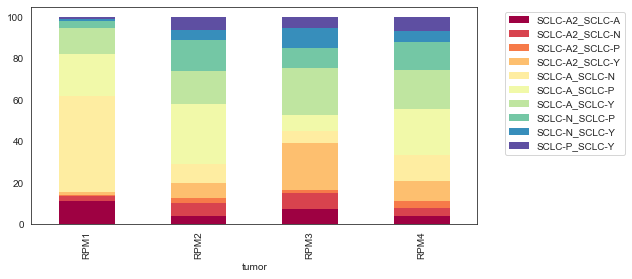

In [11]:
_adata = adata[adata.obs['Phenotype'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["tumor"], _adata.obs['Phenotype_extended']).T /
  pd.crosstab(_adata.obs["tumor"], _adata.obs['Phenotype_extended']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/rpm_tumors/phenotype_extended_barplot_rpm_tumor.pdf')

In [12]:
pd.crosstab( adata.obs['Phenotype_extended'],adata.obs['tumor']).style.background_gradient(cmap='viridis')



## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

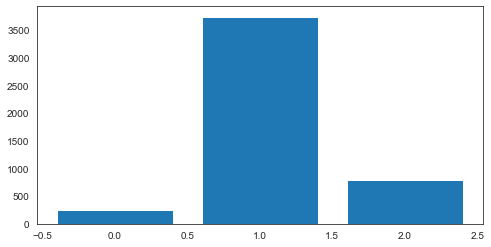

In [13]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [14]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [15]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['tumor']).style.background_gradient(cmap='viridis')

In [16]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

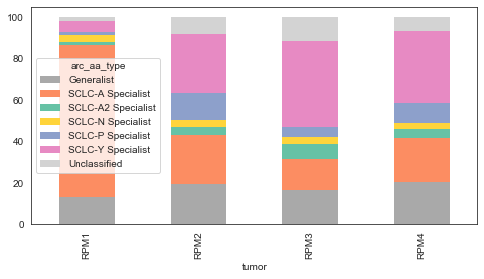

In [17]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='tumor', fname = 'rpm_tumors', pheno_name="arc_aa_type", custom_palette=color_dict)

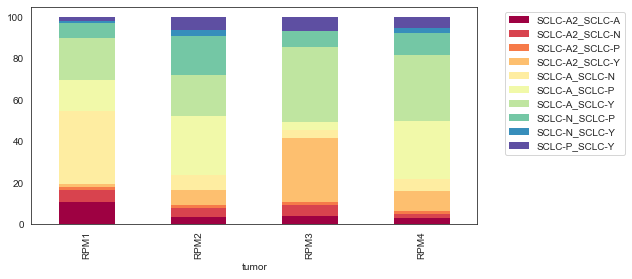

In [18]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/rpm_tumors/arc_aa_generalist_subtypes.pdf')

RPM1
Index(['SCLC-A_Score', 'SCLC-N_Score', 'SCLC-Y_Score'], dtype='object')


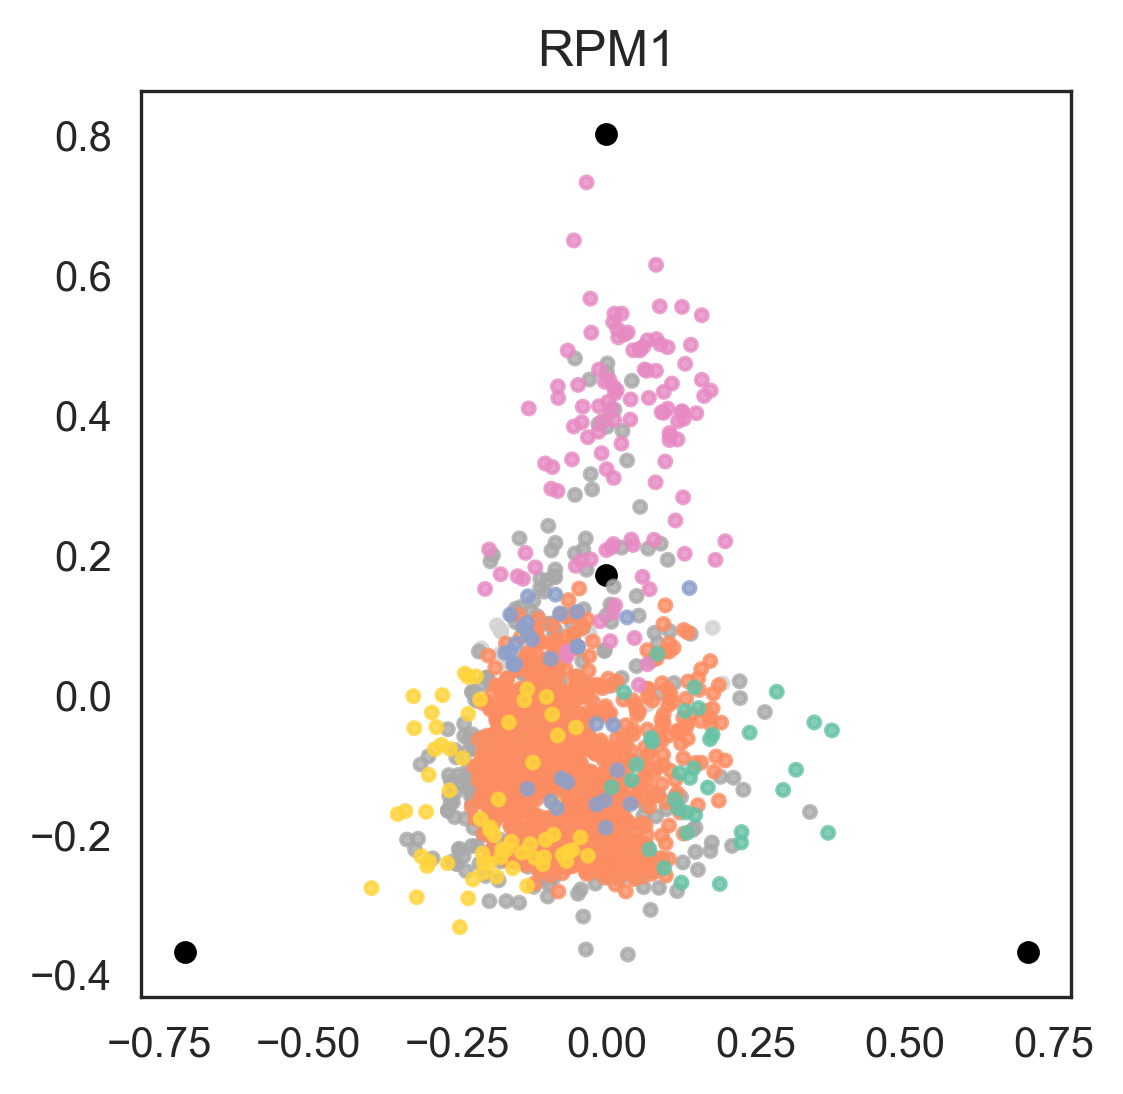

RPM2
Index(['SCLC-Y_Score', 'SCLC-A_Score', 'SCLC-P_Score'], dtype='object')


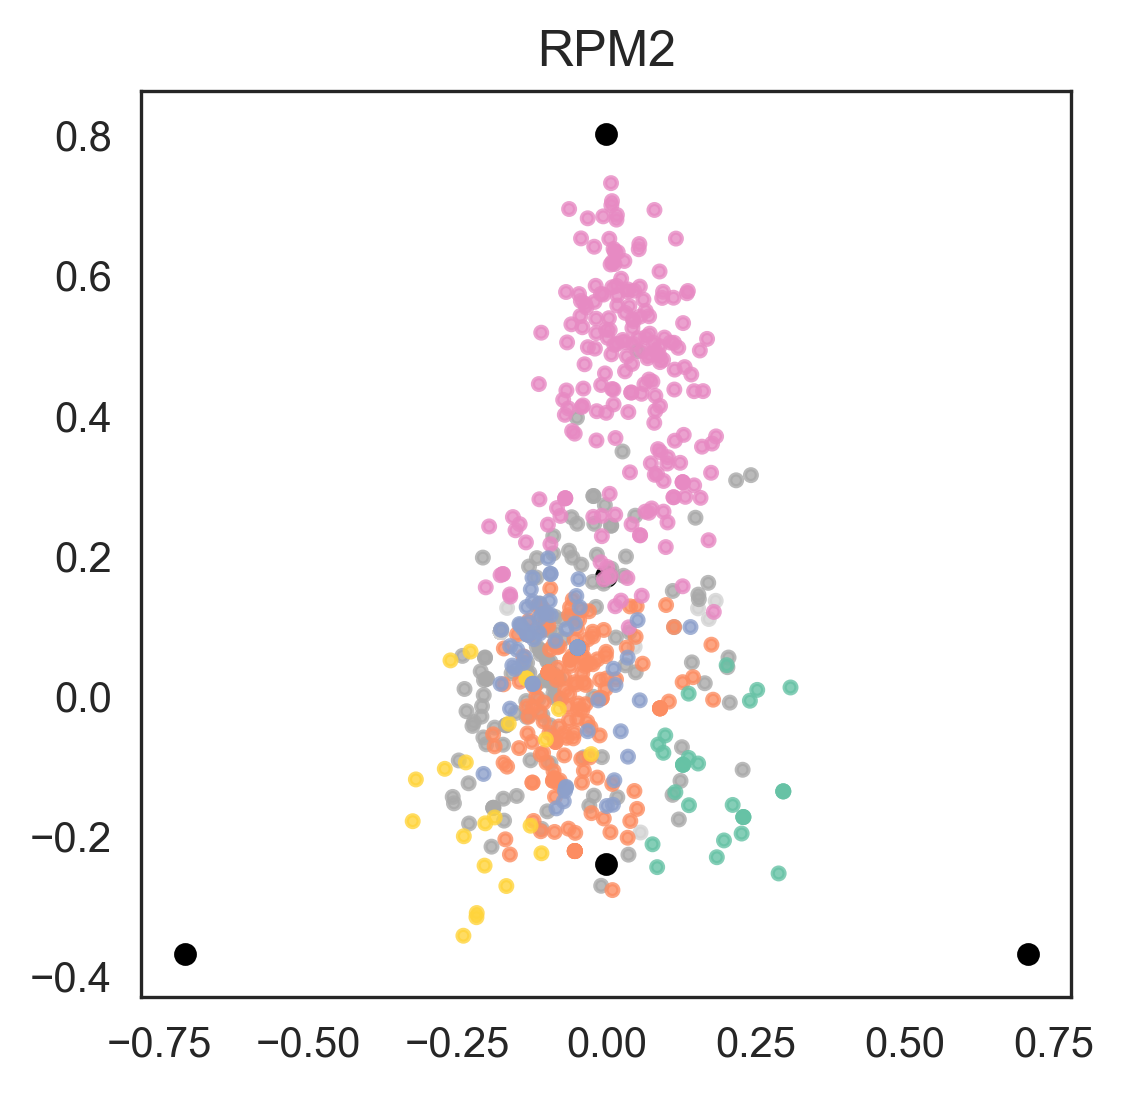

RPM3
Index(['SCLC-Y_Score', 'SCLC-A_Score', 'SCLC-A2_Score'], dtype='object')


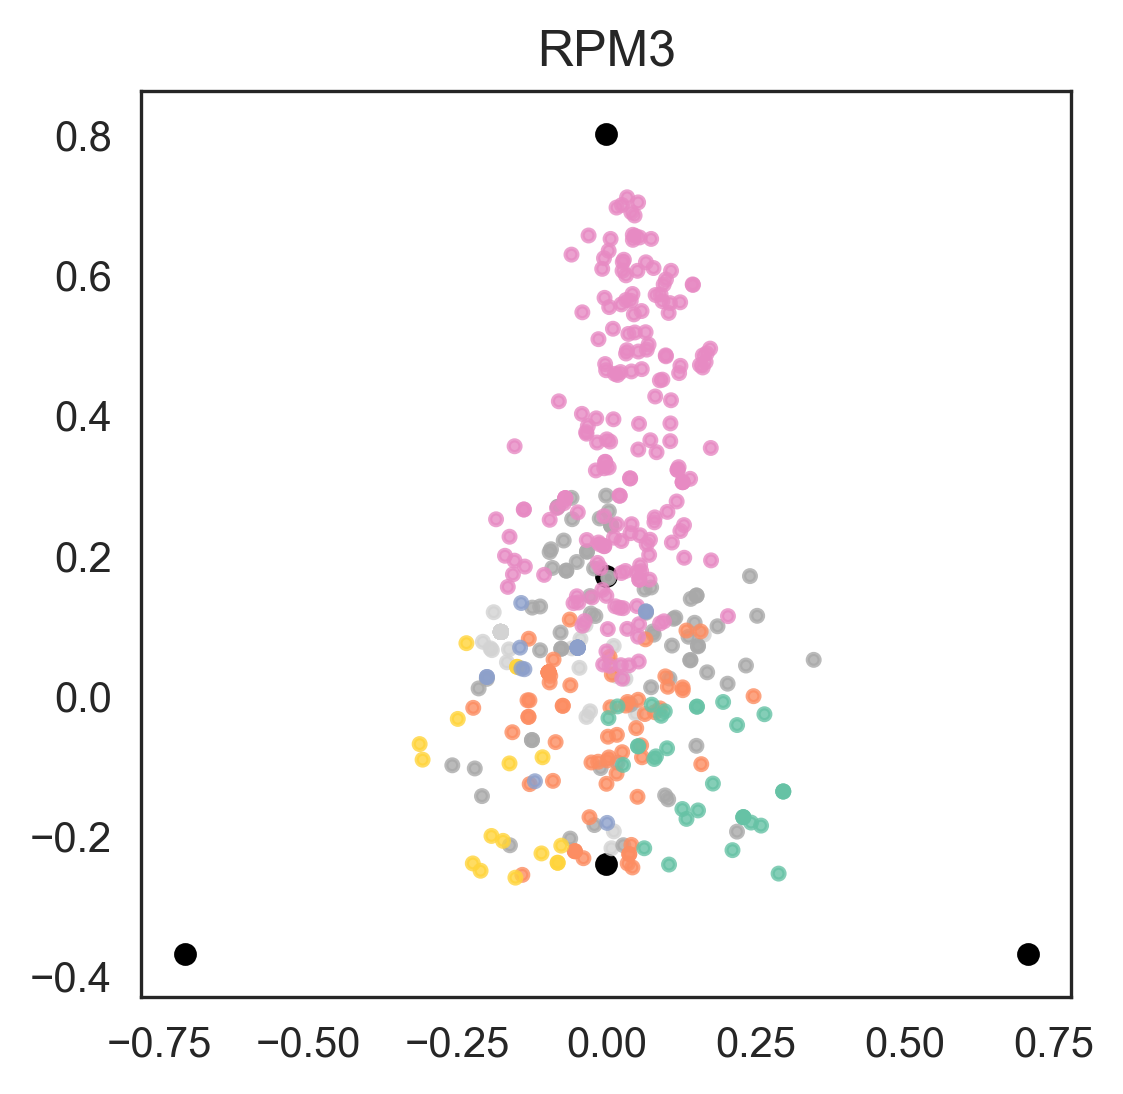

RPM4
Index(['SCLC-Y_Score', 'SCLC-A_Score', 'SCLC-N_Score'], dtype='object')


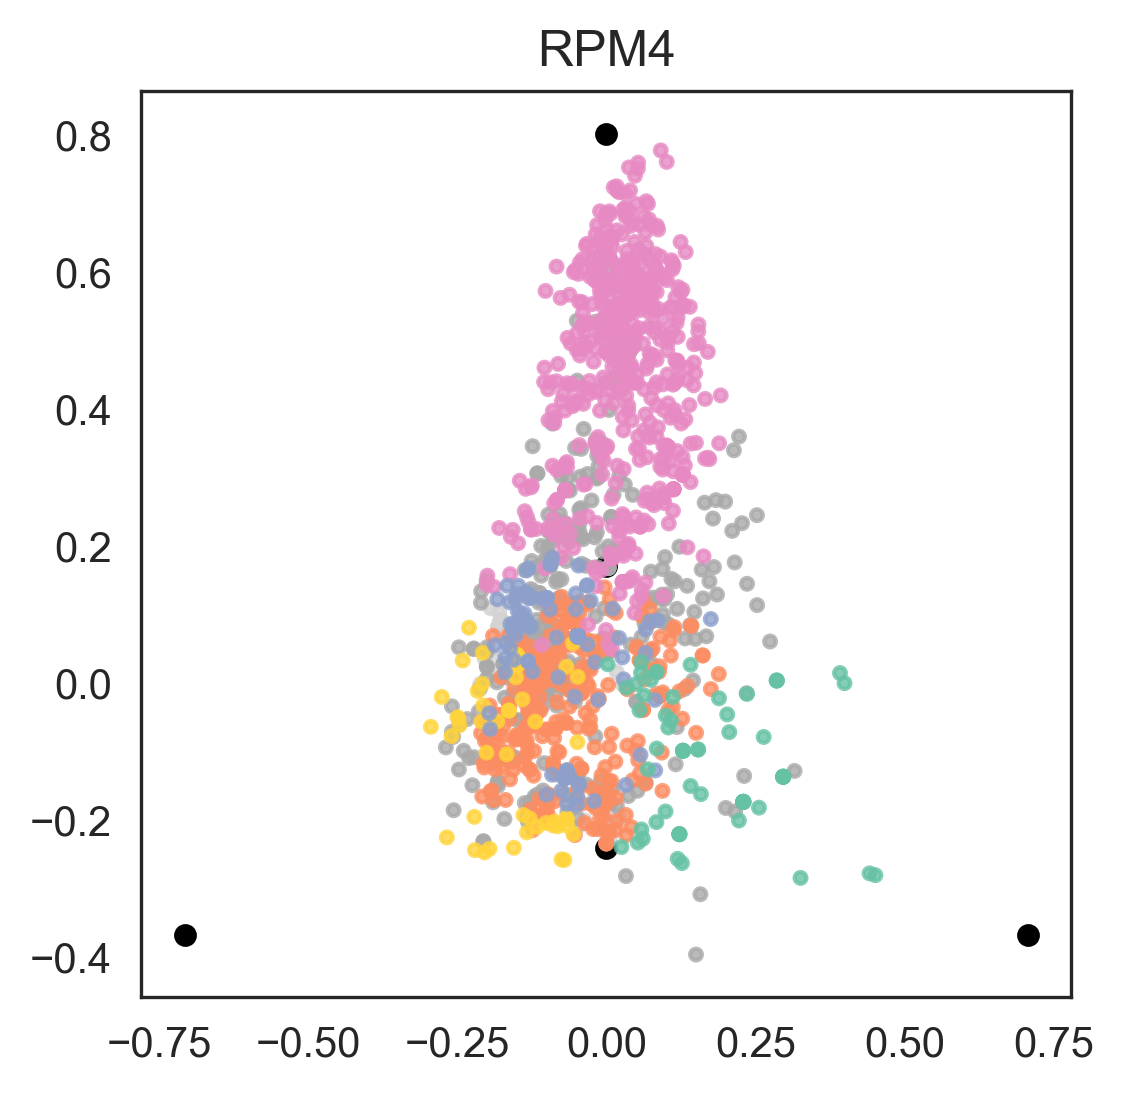

In [19]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgray', 'Unclassified': 'lightgrey'}
mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='tumor',color = 'arc_aa_type',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
                        figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False)


## Pseudotime and plasticity

We would like to see if we can get the same results as Ireland et al. did for their pseudotime analysis. To run Monocle2, we need the R interface `rpy2`. We'll also use the pseudotime inference within scvelo for comparison.

In [ ]:
# scv.tl.terminal_states(adata, groupby='tumor')

In [ ]:
# sc.pl.tsne(adata, color="end_points")

### Velocity pseudotime

In [ ]:
# Velocity pseudotime from scvelo
# scv.tl.terminal_states(adata)
# scv.tl.velocity_pseudotime(adata)
# scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', basis = 'umap')

In [ ]:
# mb.ps.velocity_paga(adata, basis='umap')

In [ ]:
# adata.write_h5ad('../int/rpm/adata03_tumor.h5ad')

In [ ]:
# adata = sc.read_h5ad('../int/rpm/adata03.h5ad')

# Calculate plasticity using CTrP

In [40]:
mb.ps.ctrp_simplified(adata, groupby = 'tumor',distance_basis='X_pca')


(RPM1)
Eigenvalues:  [1.0000008]
    identified 1 end points


Trying to set attribute `.obs` of view, copying.


[[0.01207949 0.03647266 0.03299404 ... 0.02301899 0.00971976 0.0281324 ]
 [0.02303948 0.01940044 0.020656   ... 0.02182168 0.01730253 0.01799972]
 [0.0158868  0.03006217 0.02674306 ... 0.02193718 0.01298536 0.02522922]
 ...
 [0.02420888 0.01662508 0.01803689 ... 0.02148427 0.01882638 0.01686268]
 [0.02456459 0.01533074 0.01315628 ... 0.02131194 0.02117645 0.01655044]
 [0.0305512  0.00899677 0.01131085 ... 0.01844185 0.02594946 0.01050398]]
(RPM2)
Eigenvalues:  [1.0000043]
    identified 1 end points


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


[[0.07272304 0.06231004 0.0677842  ... 0.06979803 0.07134988 0.07592853]
 [0.0708515  0.06147928 0.06587585 ... 0.07038738 0.07114869 0.07465969]
 [0.07172467 0.07029372 0.07710264 ... 0.0672803  0.06848837 0.07637801]
 ...
 [0.07172372 0.07029497 0.07710385 ... 0.0672804  0.06848811 0.07637765]
 [0.0734086  0.06656711 0.07318636 ... 0.06674499 0.06879608 0.07650455]
 [0.07203845 0.06883297 0.07432777 ... 0.06904552 0.06512491 0.07496922]]
(RPM3)
Eigenvalues:  [1.0000015 0.9999036]
    identified 2 end points
[[0.05082752 0.04841363 0.01507854 ... 0.05670474 0.07689796 0.05318234]
 [0.04460167 0.09168582 0.01901709 ... 0.04839631 0.06870907 0.0516438 ]
 [0.04468693 0.09278021 0.01888761 ... 0.0483609  0.06808271 0.05181086]
 ...
 [0.04462564 0.09525204 0.01866137 ... 0.04819829 0.06706238 0.05182564]
 [0.04457993 0.09562805 0.01867642 ... 0.04815936 0.06698237 0.05172691]
 [0.04465282 0.0927619  0.01889456 ... 0.04834813 0.06811148 0.05177915]]
(RPM4)
Eigenvalues:  [1.0000023 1.0000023

Trying to set attribute `.obs` of view, copying.


[[0.02528627 0.02369019 0.02946248 ... 0.02690822 0.00018223 0.03074859]
 [0.02422043 0.02316378 0.03245238 ... 0.02855099 0.00016298 0.03231091]
 [0.0225527  0.02132318 0.02755061 ... 0.02440771 0.04934544 0.02727581]
 ...
 [0.0242203  0.02319748 0.03232936 ... 0.02860872 0.00018636 0.03214884]
 [0.02491967 0.02345525 0.03085898 ... 0.02721928 0.00599967 0.03086616]
 [0.02421302 0.0232054  0.03231525 ... 0.02860886 0.00017717 0.03212921]]


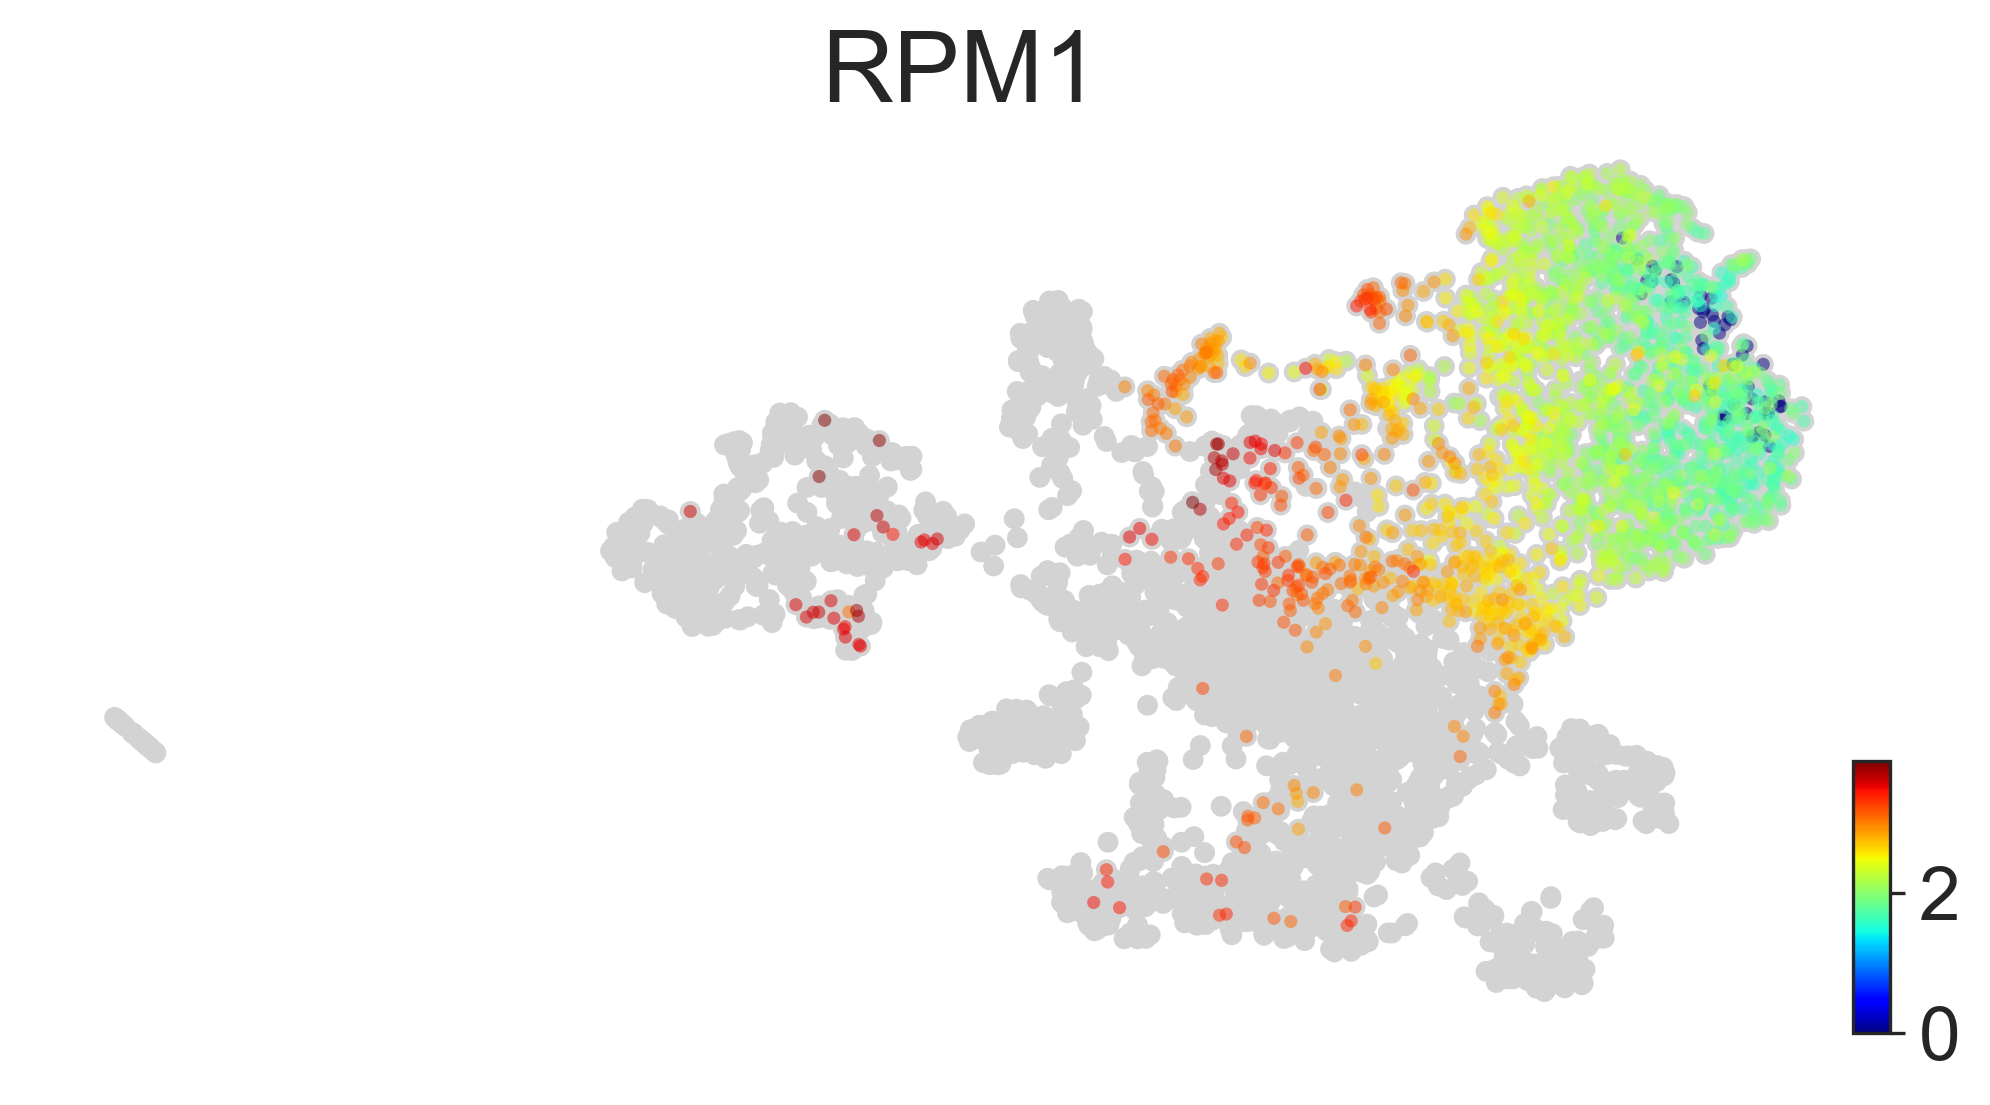

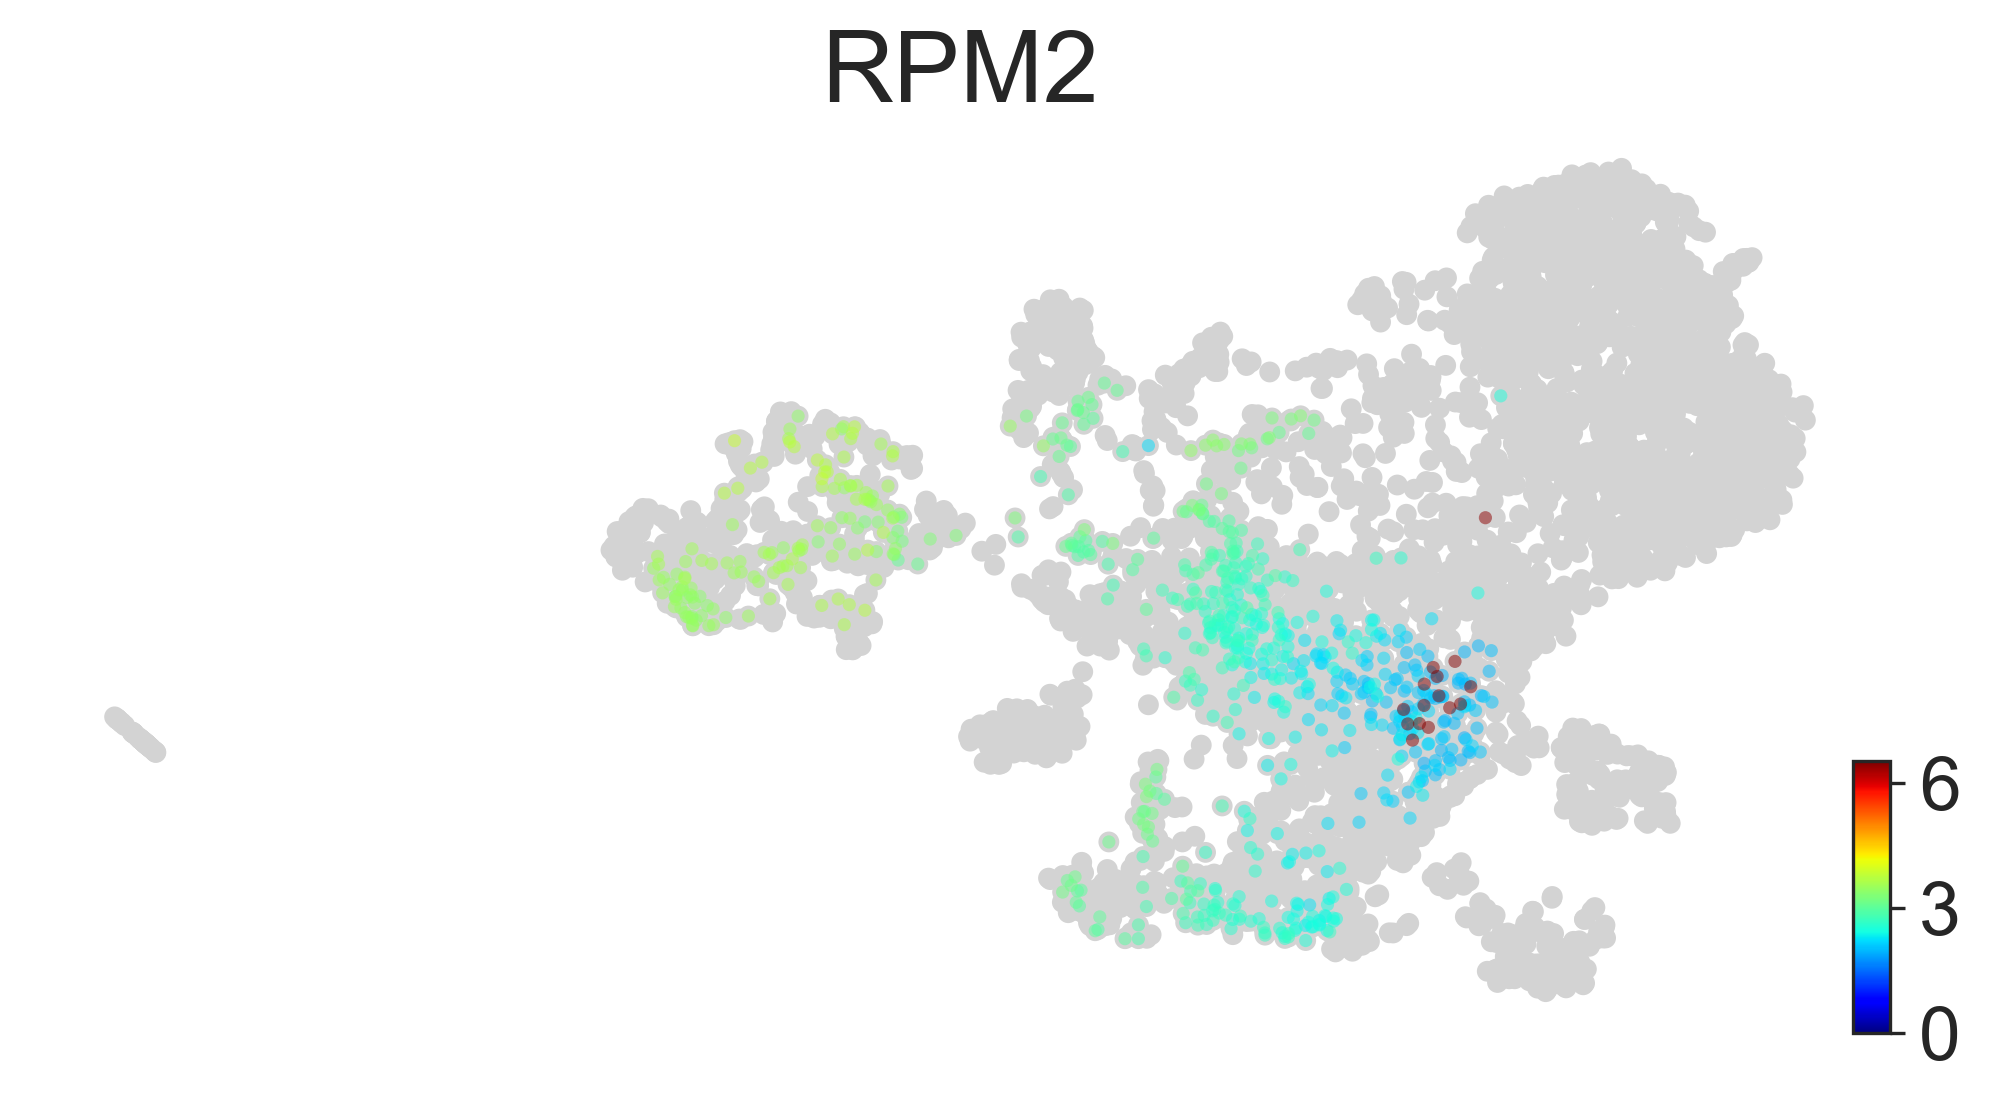

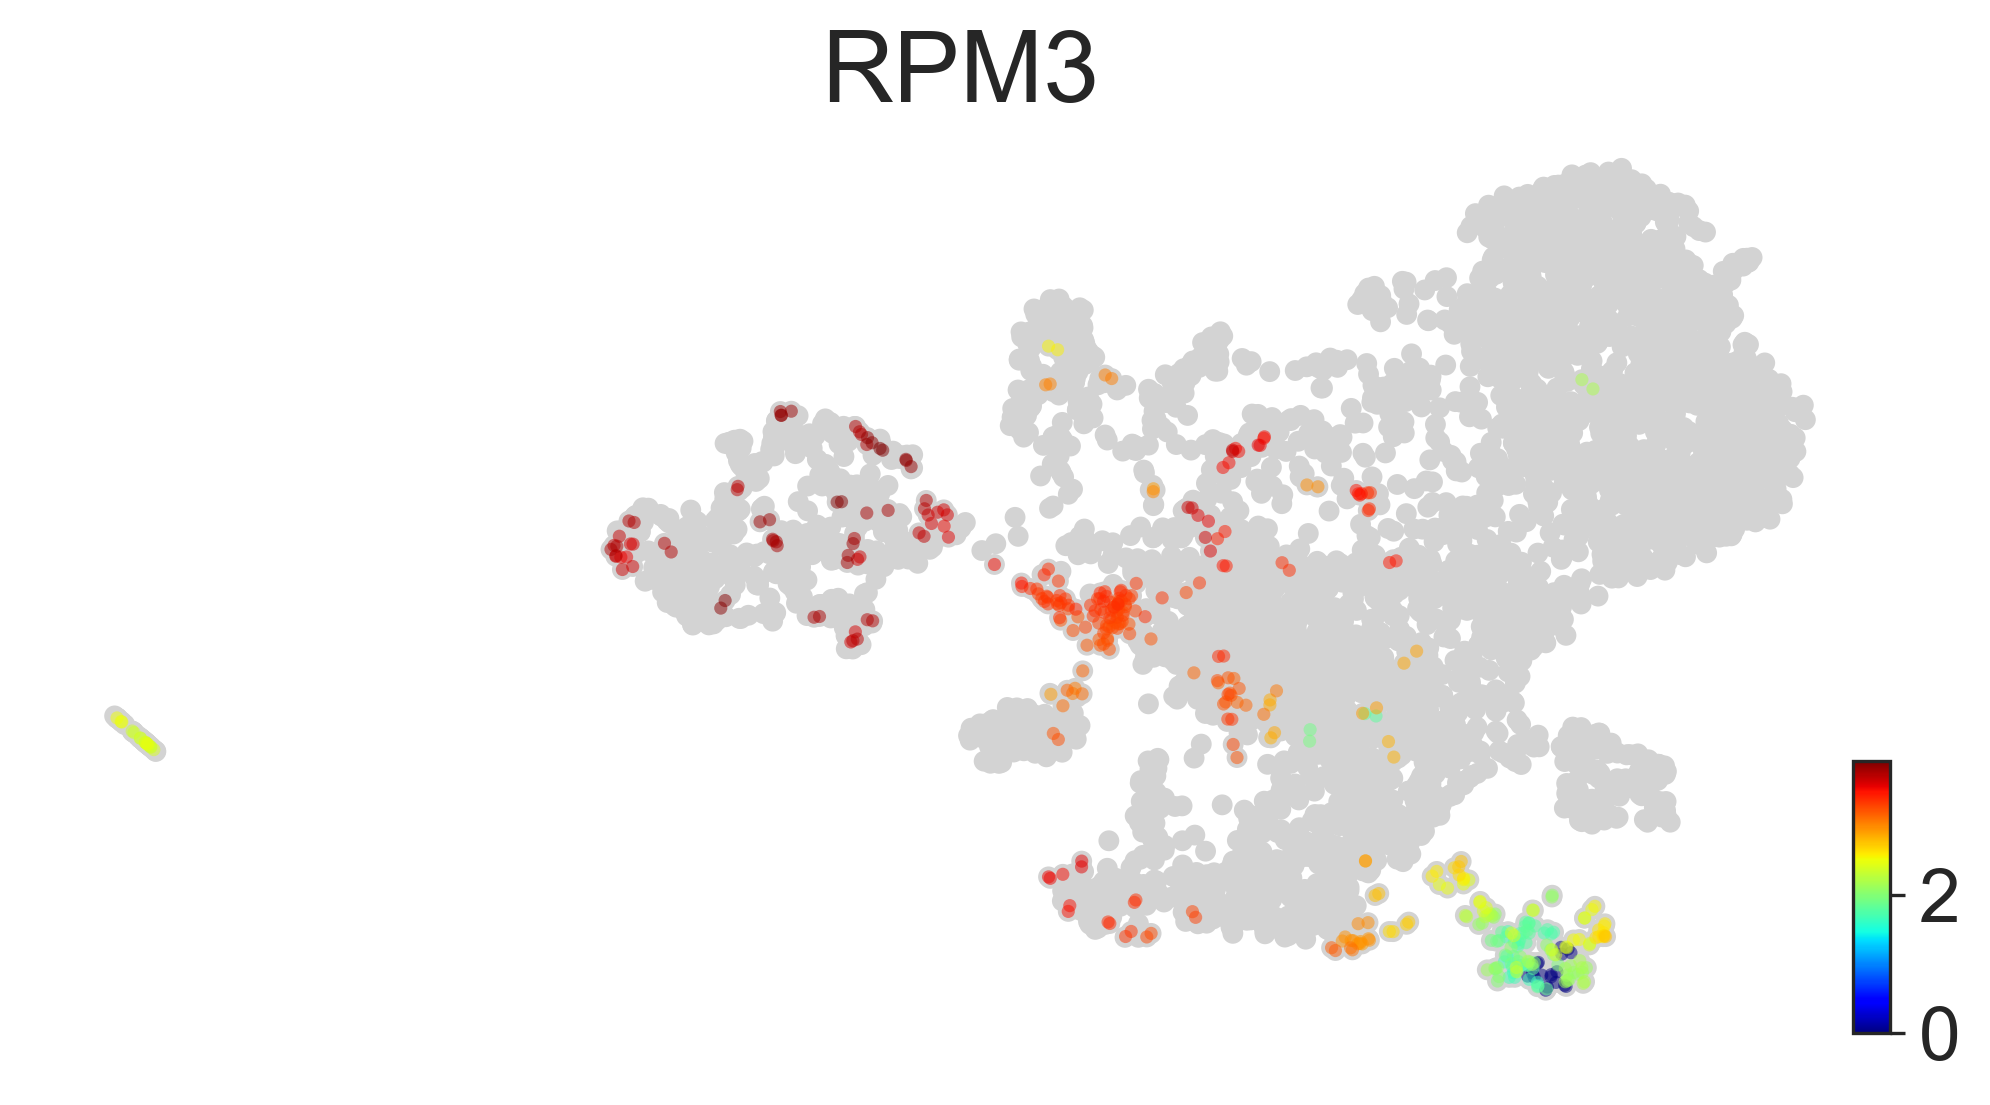

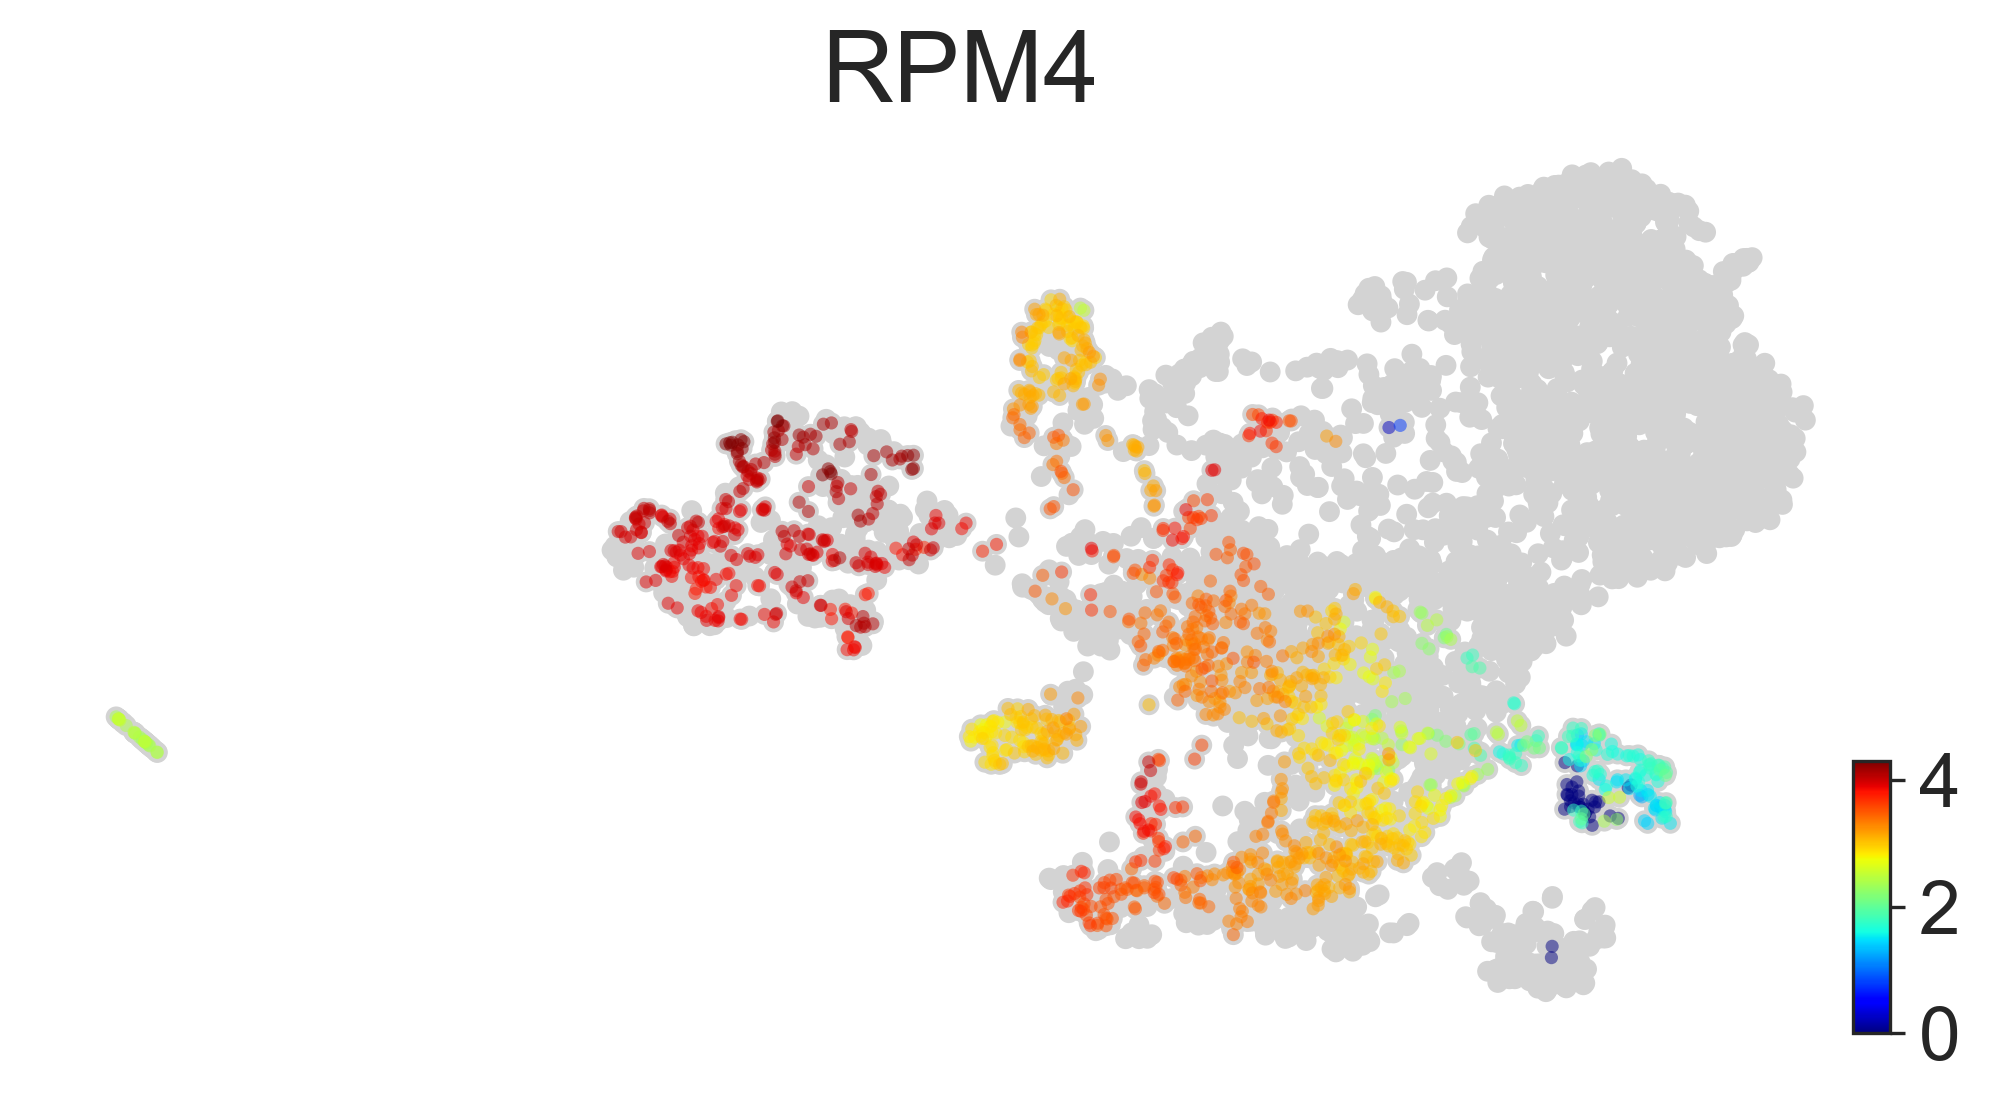

In [41]:
mb.pl.ctrp_groups(adata, groups = 'tumor', basis = 'umap')


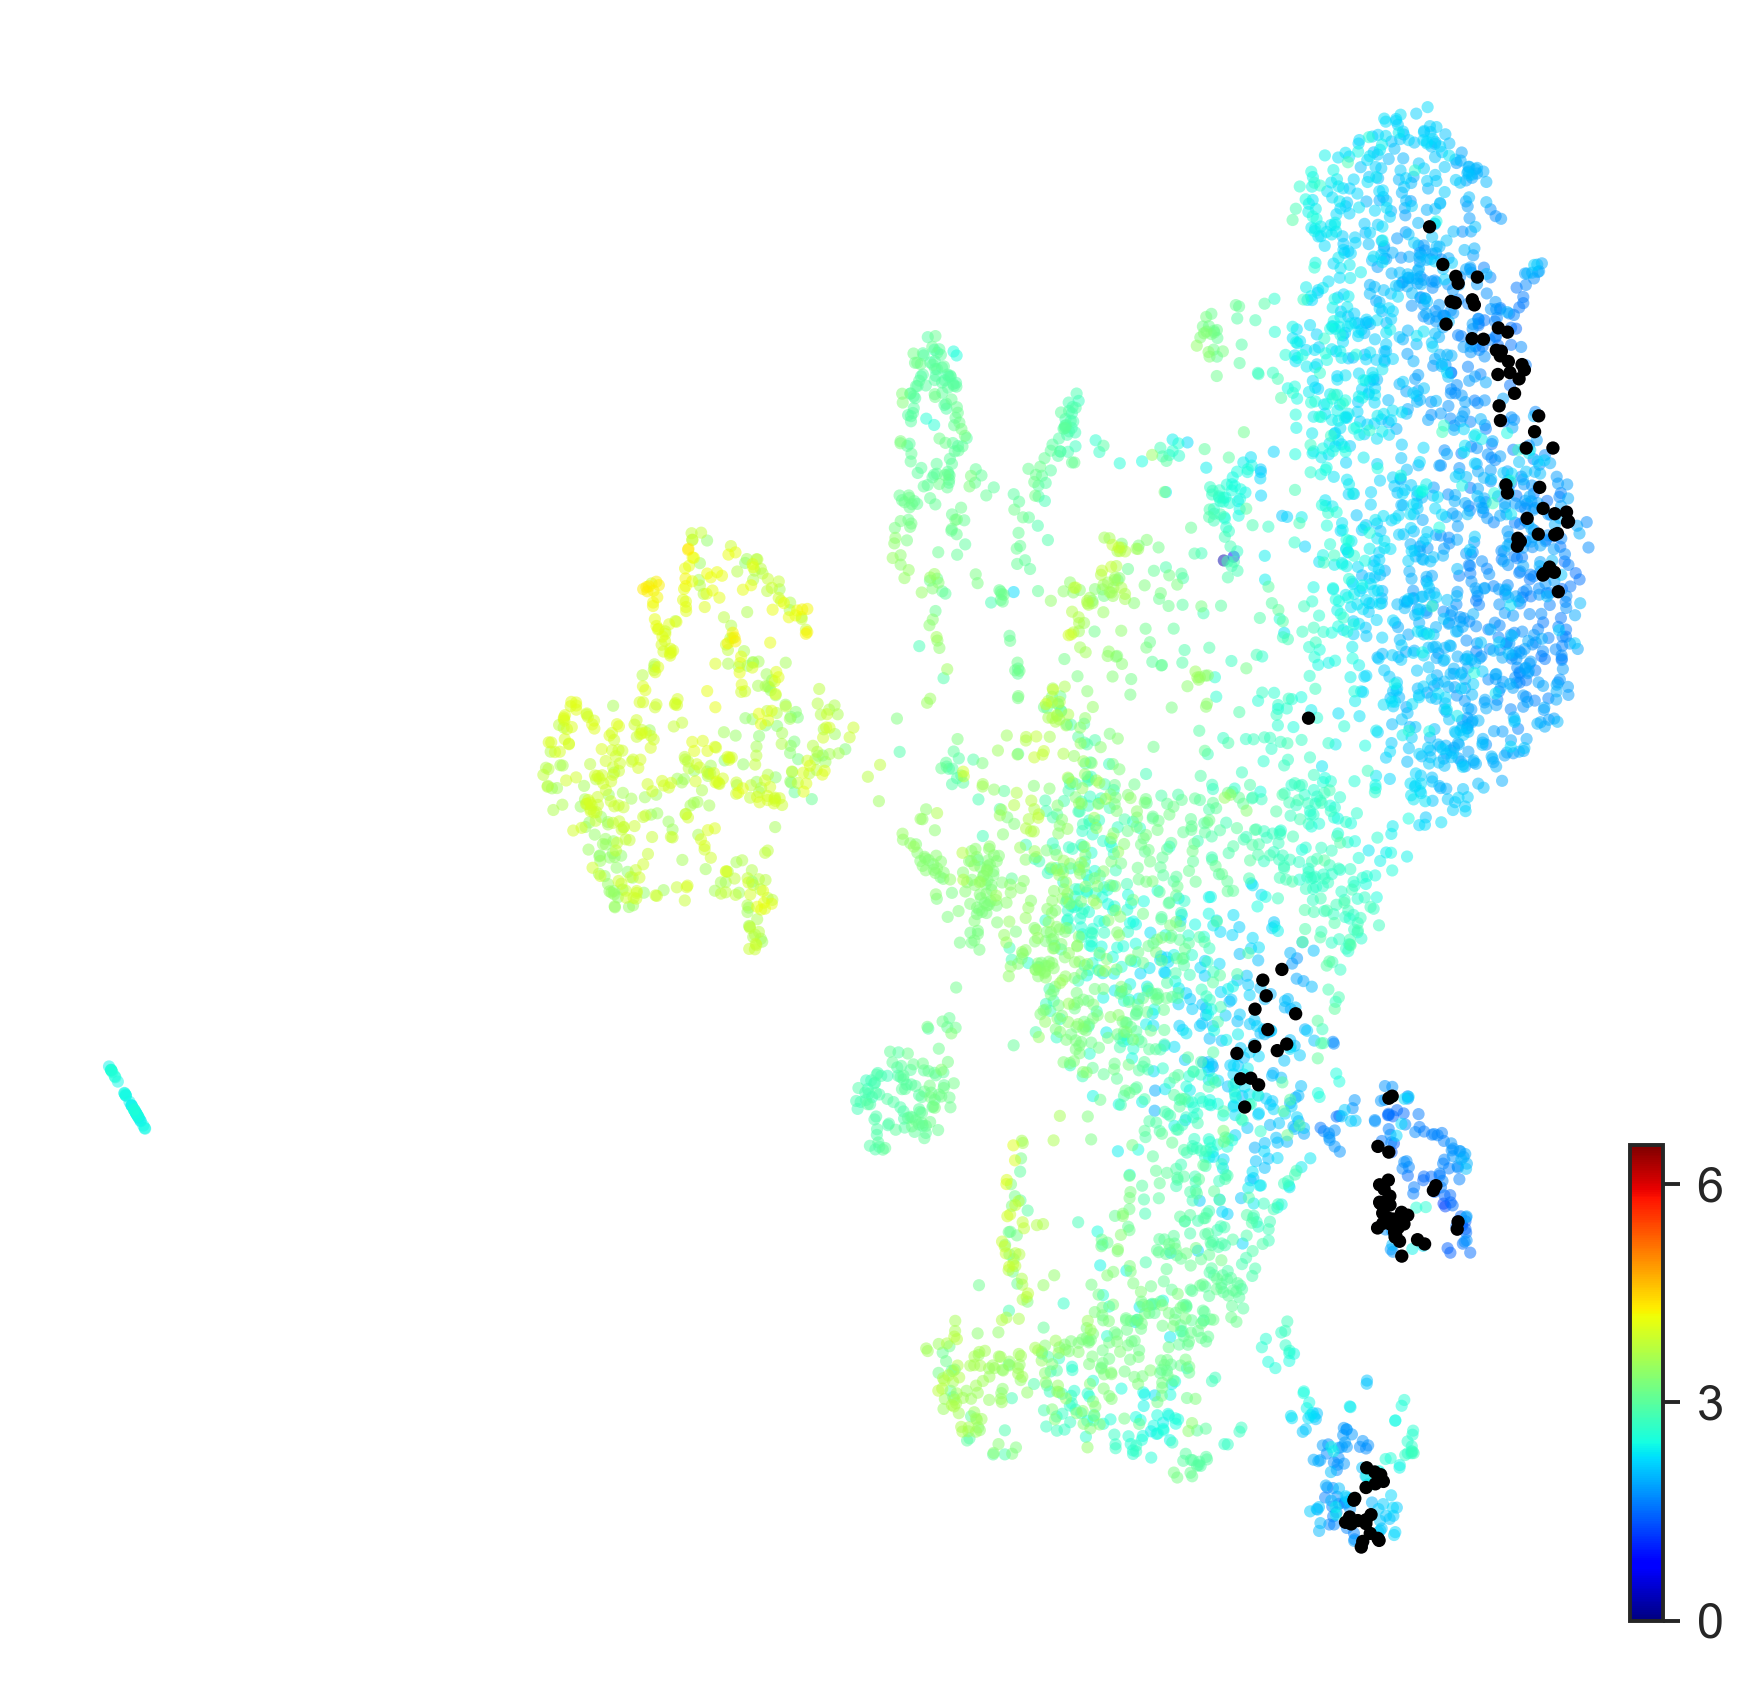

In [33]:
mb.pl.ctrp(adata, basis = 'umap')

### Sankey diagram

In [143]:
from scvelo.preprocessing.neighbors import get_connectivities
sankey = {}
sankey_prob = {}
for c in adata.obs['tumor'].cat.categories:
    _adata = adata[adata.obs['tumor']== c]

    connectivities = get_connectivities(_adata, 'distances')

    T = scv.tl.transition_matrix(_adata, vkey='velocity', basis=None,  weight_diffusion=0, scale_diffusion=1,
                                 self_transitions=True, backward=False)
    T = T.todense()
    #Calcuate N, the fundamental matrix
    Q, ends = mb.ps.extract_Q(T, connectivities = connectivities, eigen=True,eps = 1e-2)
    t_ind,r_ind = mb.ps.return_t_r_indices(T, connectivities = connectivities,eigen = True, eps = 1e-2)
    R = T[t_ind.reshape(-1, 1), r_ind]
    N = mb.ps.compute_N(Q)
    p_absorbing = N.dot(R)
    P_abs_df = pd.DataFrame(p_absorbing, columns = _adata.obs.iloc[r_ind].index, index = _adata.obs.iloc[t_ind].index)
    P_abs_df['A'] = P_abs_df.index
    P_abs_df['Source_subtype'] = [_adata.obs.loc[i]['Phenotype'] for i in P_abs_df.index]
    P_df = pd.melt(P_abs_df, id_vars=['A','Source_subtype'],value_vars=_adata.obs.iloc[r_ind].index)
    P_df.columns = ['A','Source_subtype','B','value']

    P_df['sink_subtype'] = [_adata.obs.loc[i]['Phenotype'] for i in P_df['B']]
    sankey_prob[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()/P_df.groupby(['Source_subtype']).sum()
    sankey[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()

# mb.ps.p_absorbing(adata.obs[adata.obs['cline']== 'H841'])



Eigenvalues:  [1.0000011]
    identified 1 end points
Eigenvalues:  [1.0000056  0.99879366]
    identified 2 end points
Eigenvalues:  [1.0000017  0.99990463 0.9953212  0.9903073 ]
    identified 4 end points
Eigenvalues:  [1.0000032  1.0000005  0.9962683  0.99178743]
    identified 4 end points


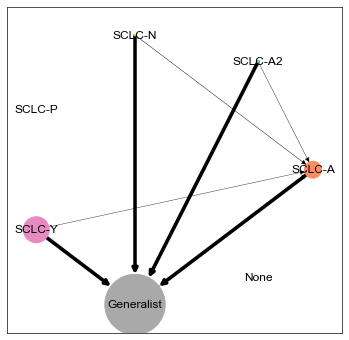

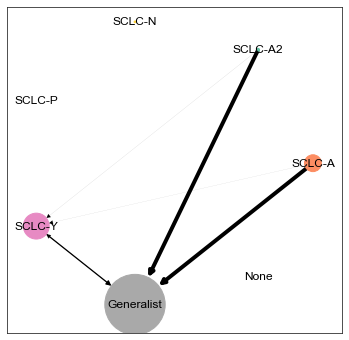

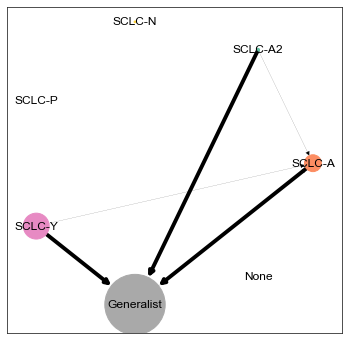

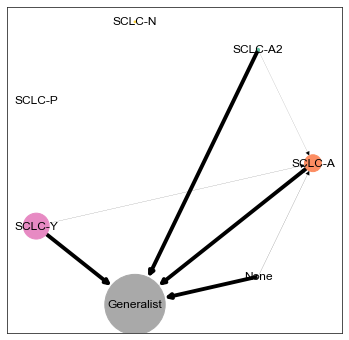

In [158]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
for c in adata.obs['tumor'].cat.categories:
    G = nx.DiGraph()
    G.add_nodes_from(subtypes)
    G.add_weighted_edges_from([r.values for i,r in sankey_prob[c]['value'].reset_index().iterrows()])
    cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']

    color_dict = {'SCLC-Y': cp[4], 'SCLC-A': cp[0], 'SCLC-A2': cp[1], 'SCLC-N': cp[2], 'SCLC-P': cp[3],
                  'Generalist': 'darkgray', 'None': 'lightgray'}

    node_colors = []
    node_size = []

    for node in G.nodes():
        node_colors.append(color_dict[node])
        node_size.append(list(adata.obs['Phenotype'].values).count(node))

    edges = G.edges()
    G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
    # colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*4 for u,v in edges]
    pos=nx.circular_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
    fig = plt.figure(figsize = (6,6))
    nx.draw_networkx(G,pos, width = weights, node_color = node_colors, node_size = node_size, \
                     connectionstyle = 'arc3')

#     A = to_agraph(G) 
#     for node in G.nodes():
#         n = A.get_node(node)
#         n.attr['color'] = color_dict[node]
#     A.node_attr["fontsize"] = "8"
#     A.edge_attr["fontsize"] = "8"

#     A.node_attr["style"] = "filled"
#     # A.node_attr['label'] = ''

#     for edge in G.edges():
#         e = A.get_edge(edge[0], edge[1])
#         e.attr['label'] = str(np.round(G[edge[0]][edge[1]]['weight']*100,2)) + "%"


#     A.layout('dot') 
#     A.draw(f"./figures/popD_networks/{c}.pdf", prog="neato", args="-n2")


In [164]:
color_dict

{'SCLC-Y': '#e78ac3',
 'SCLC-A': '#fc8d62',
 'SCLC-A2': '#66c2a5',
 'SCLC-N': '#FFD43B',
 'SCLC-P': '#8da0cb',
 'Generalist': 'darkgray',
 'None': 'lightgray'}

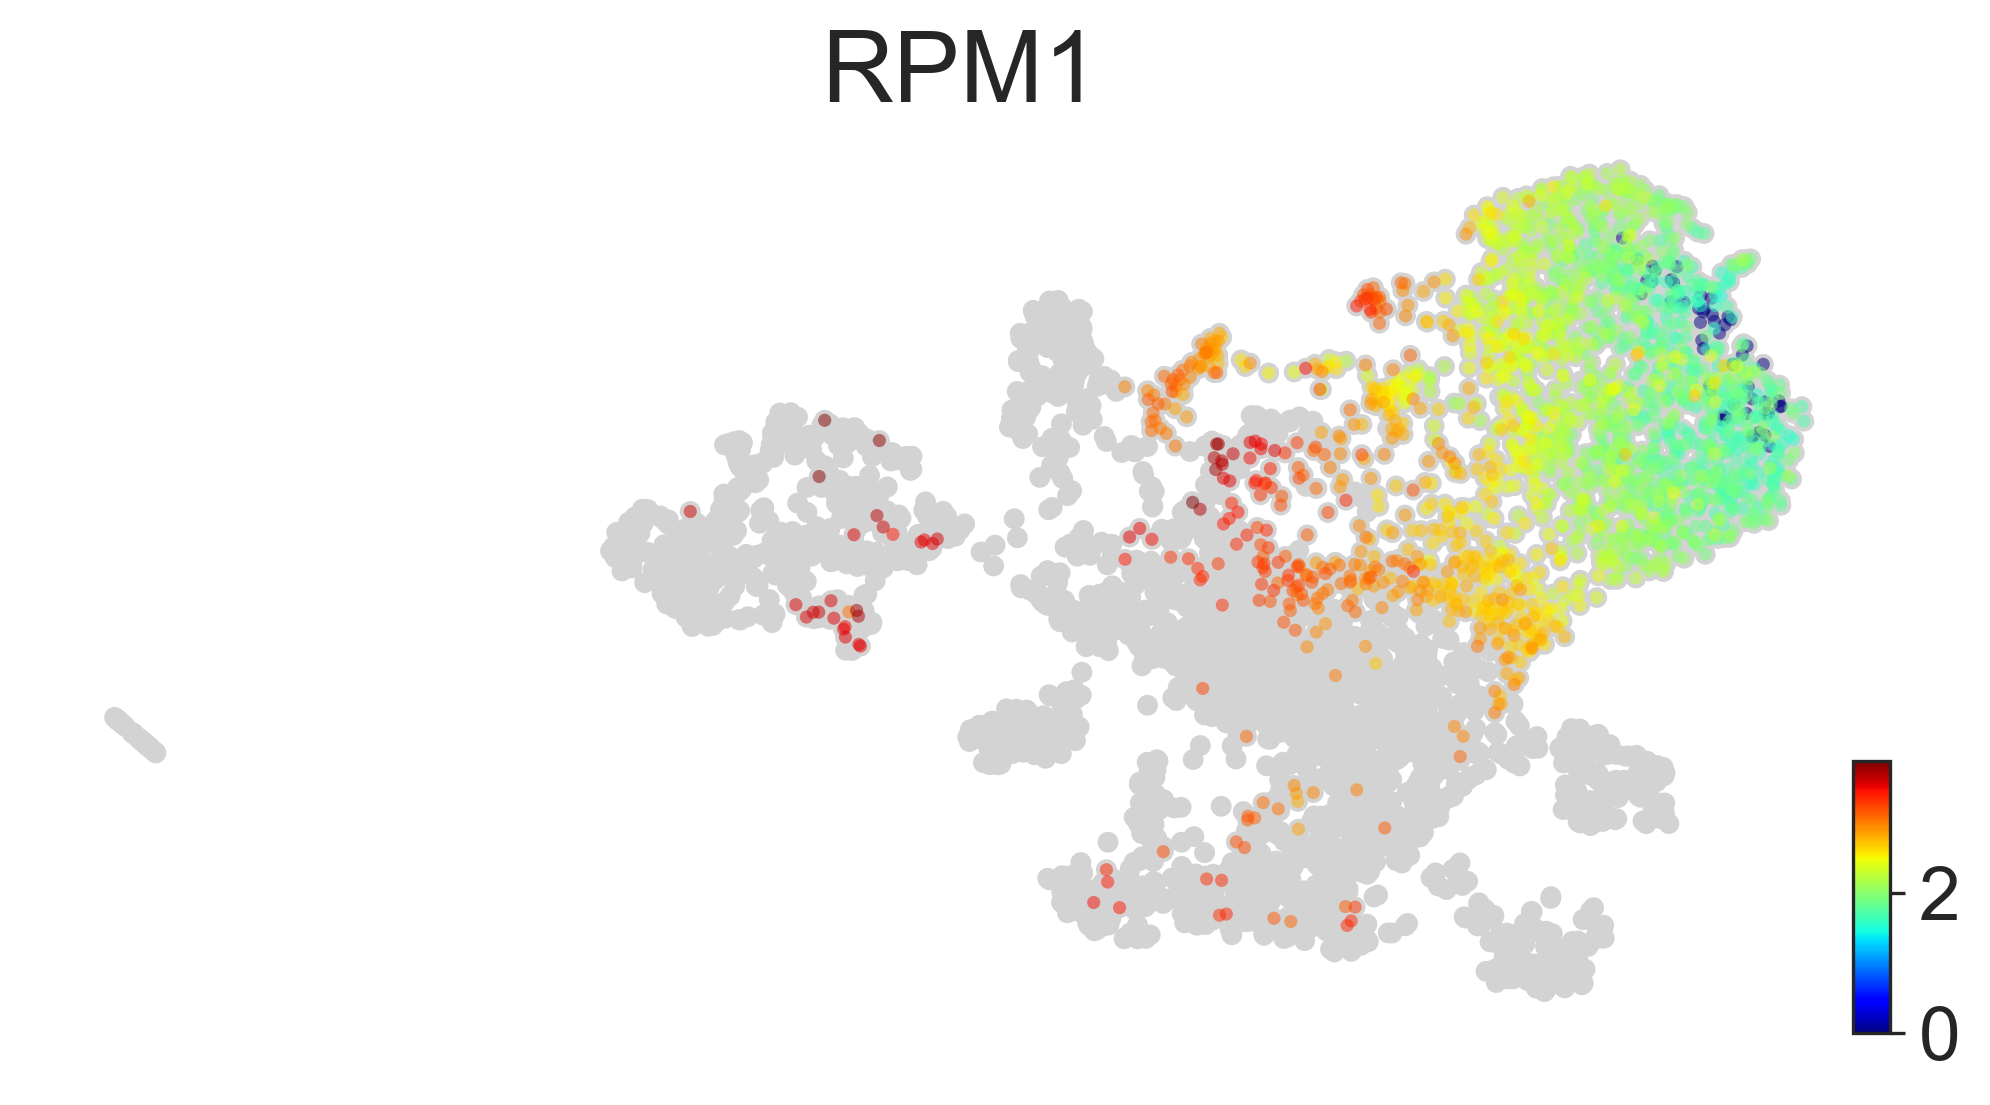

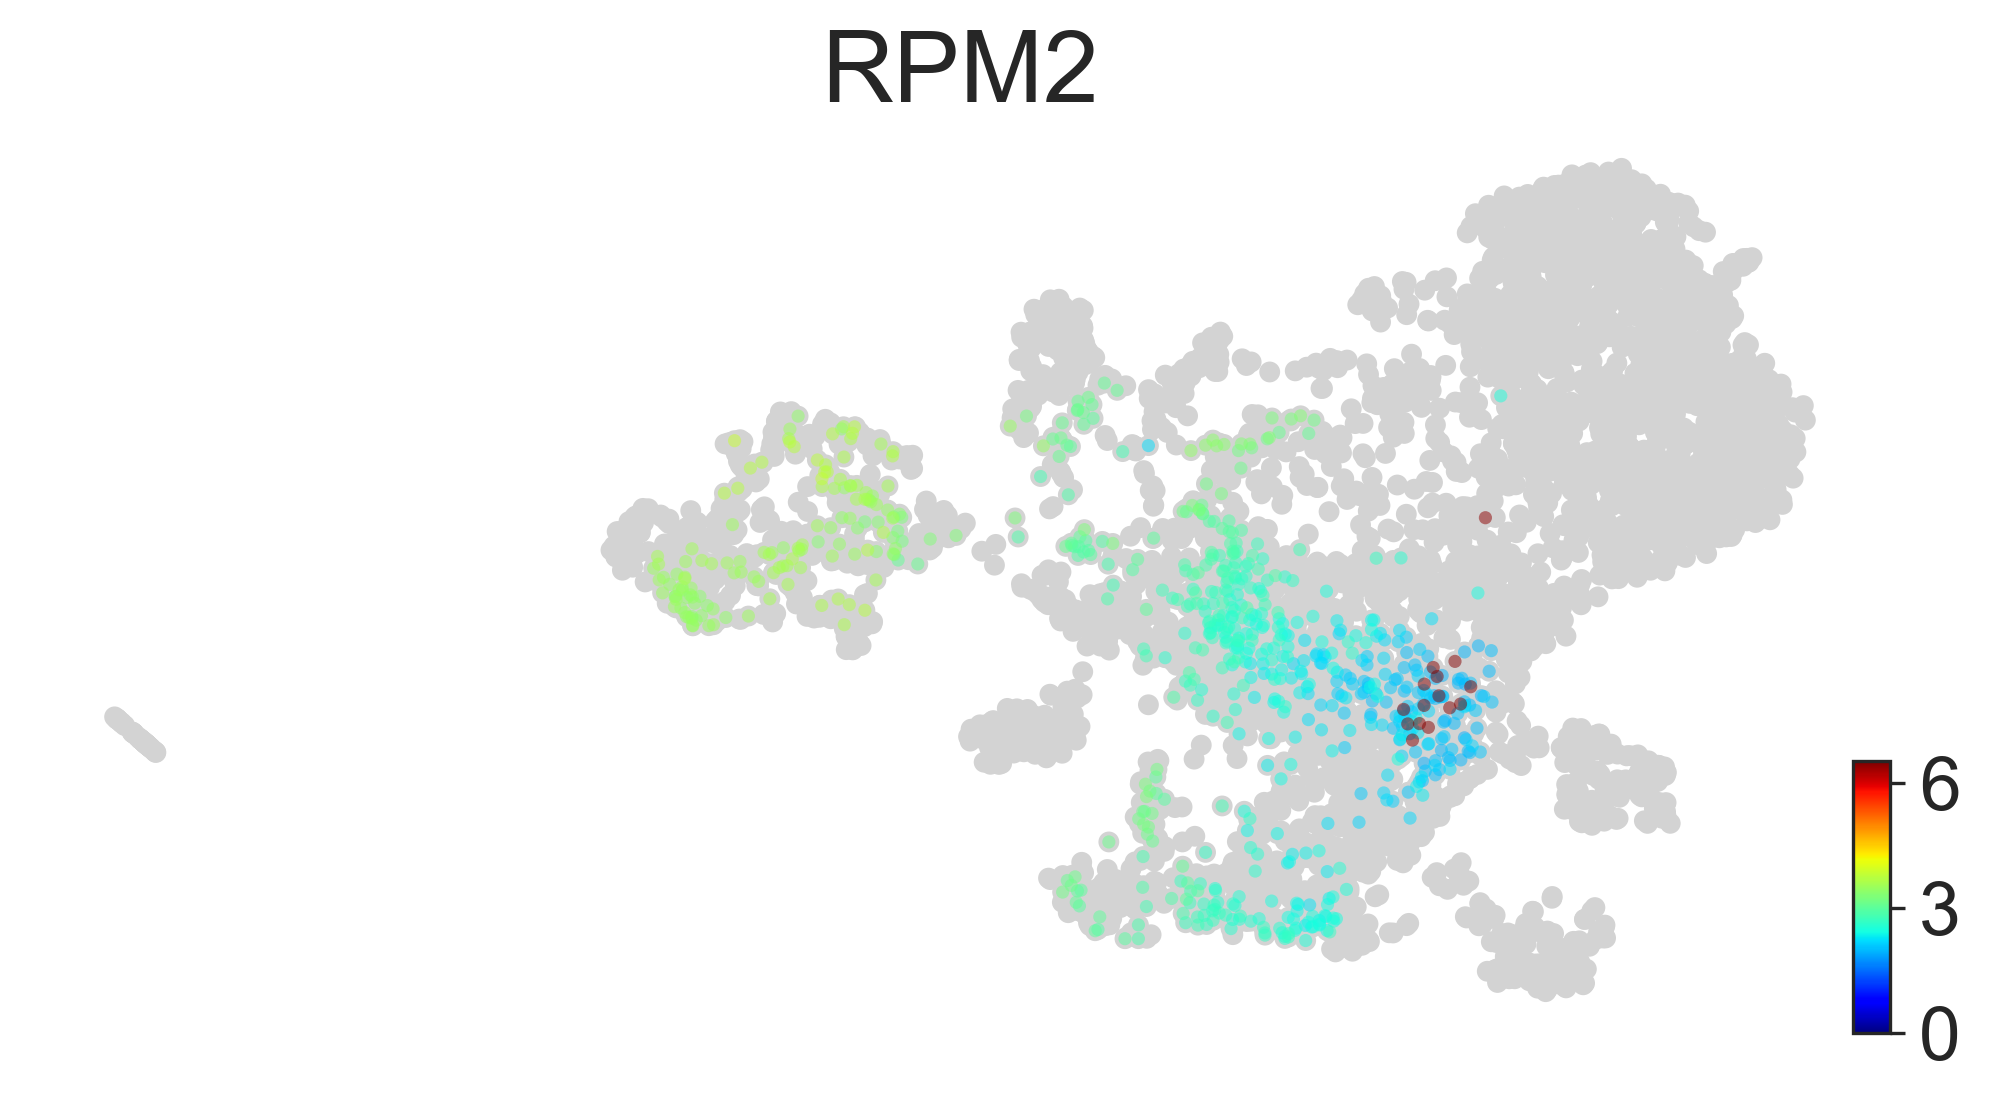

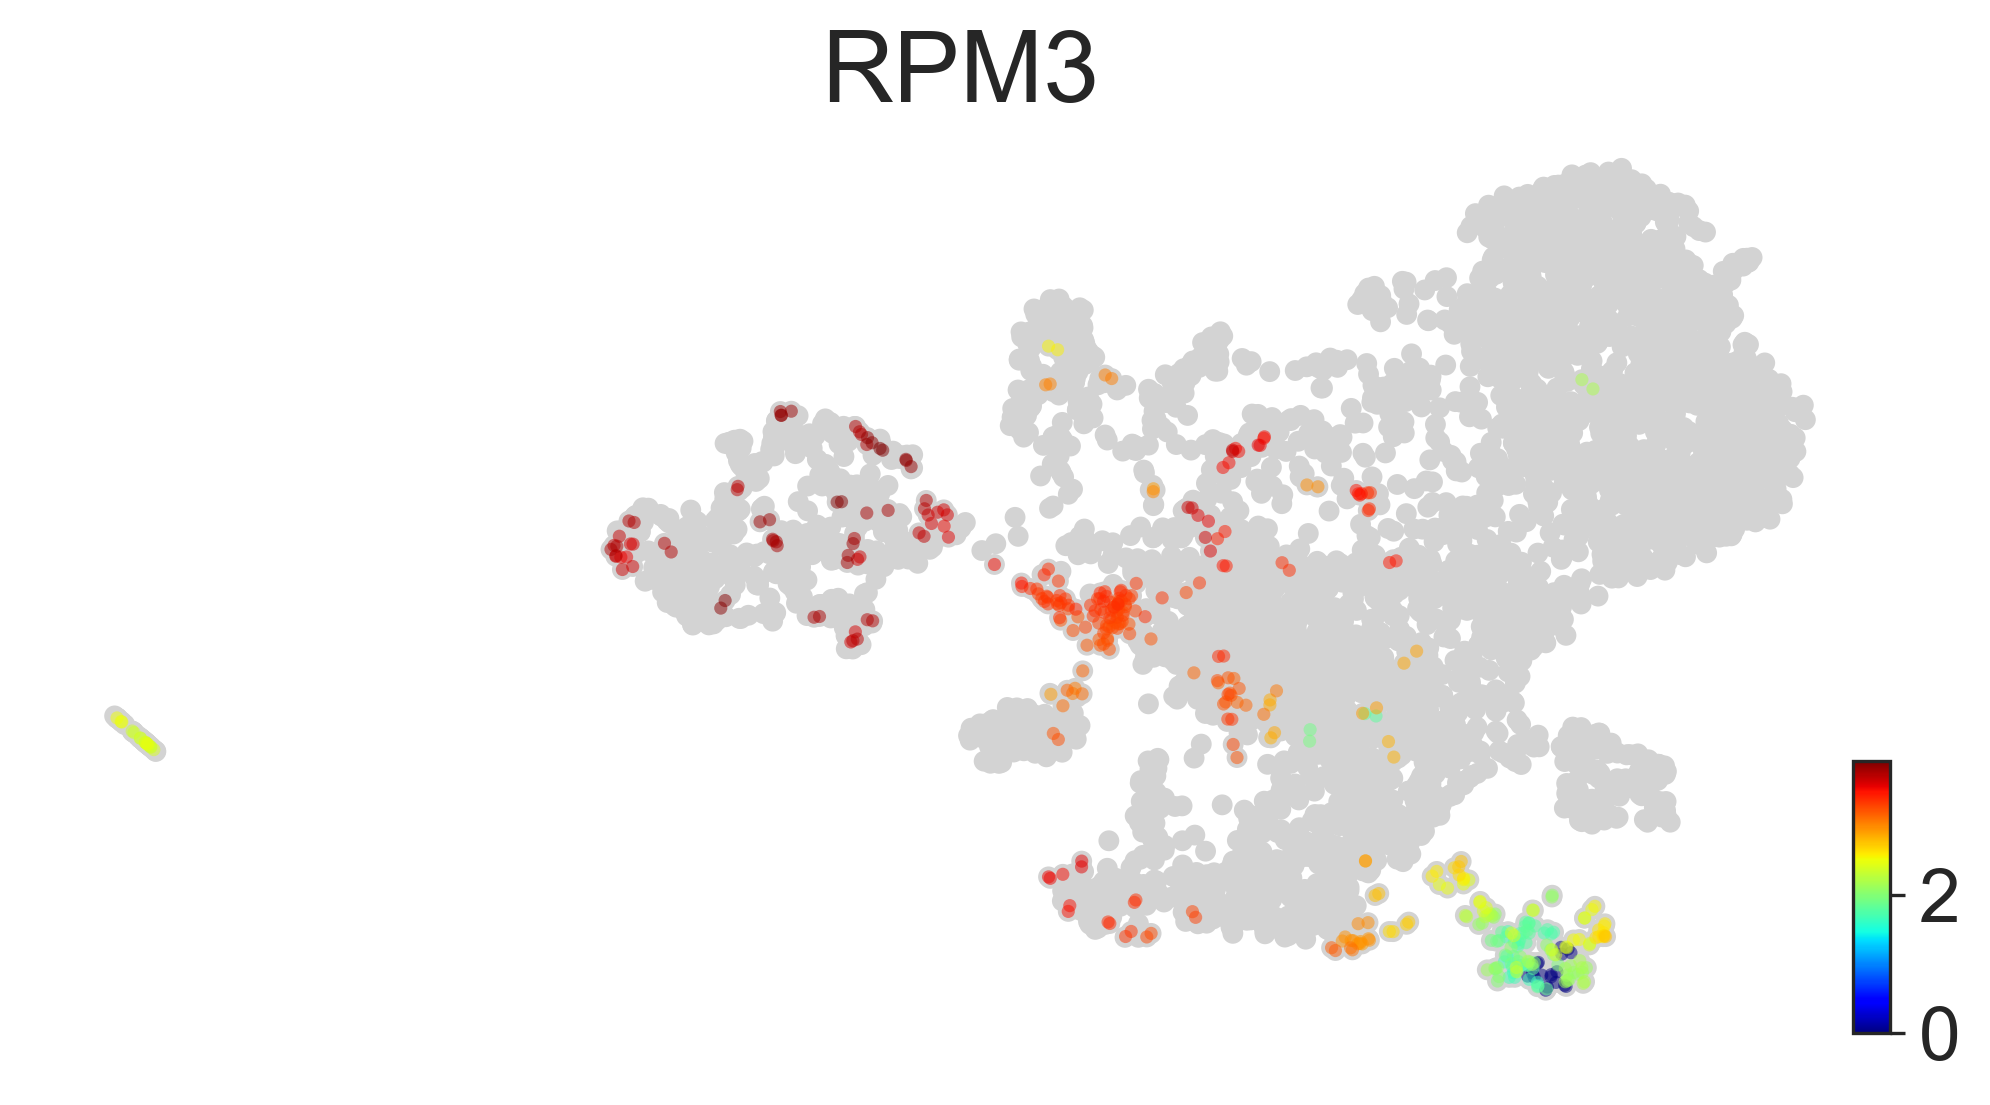

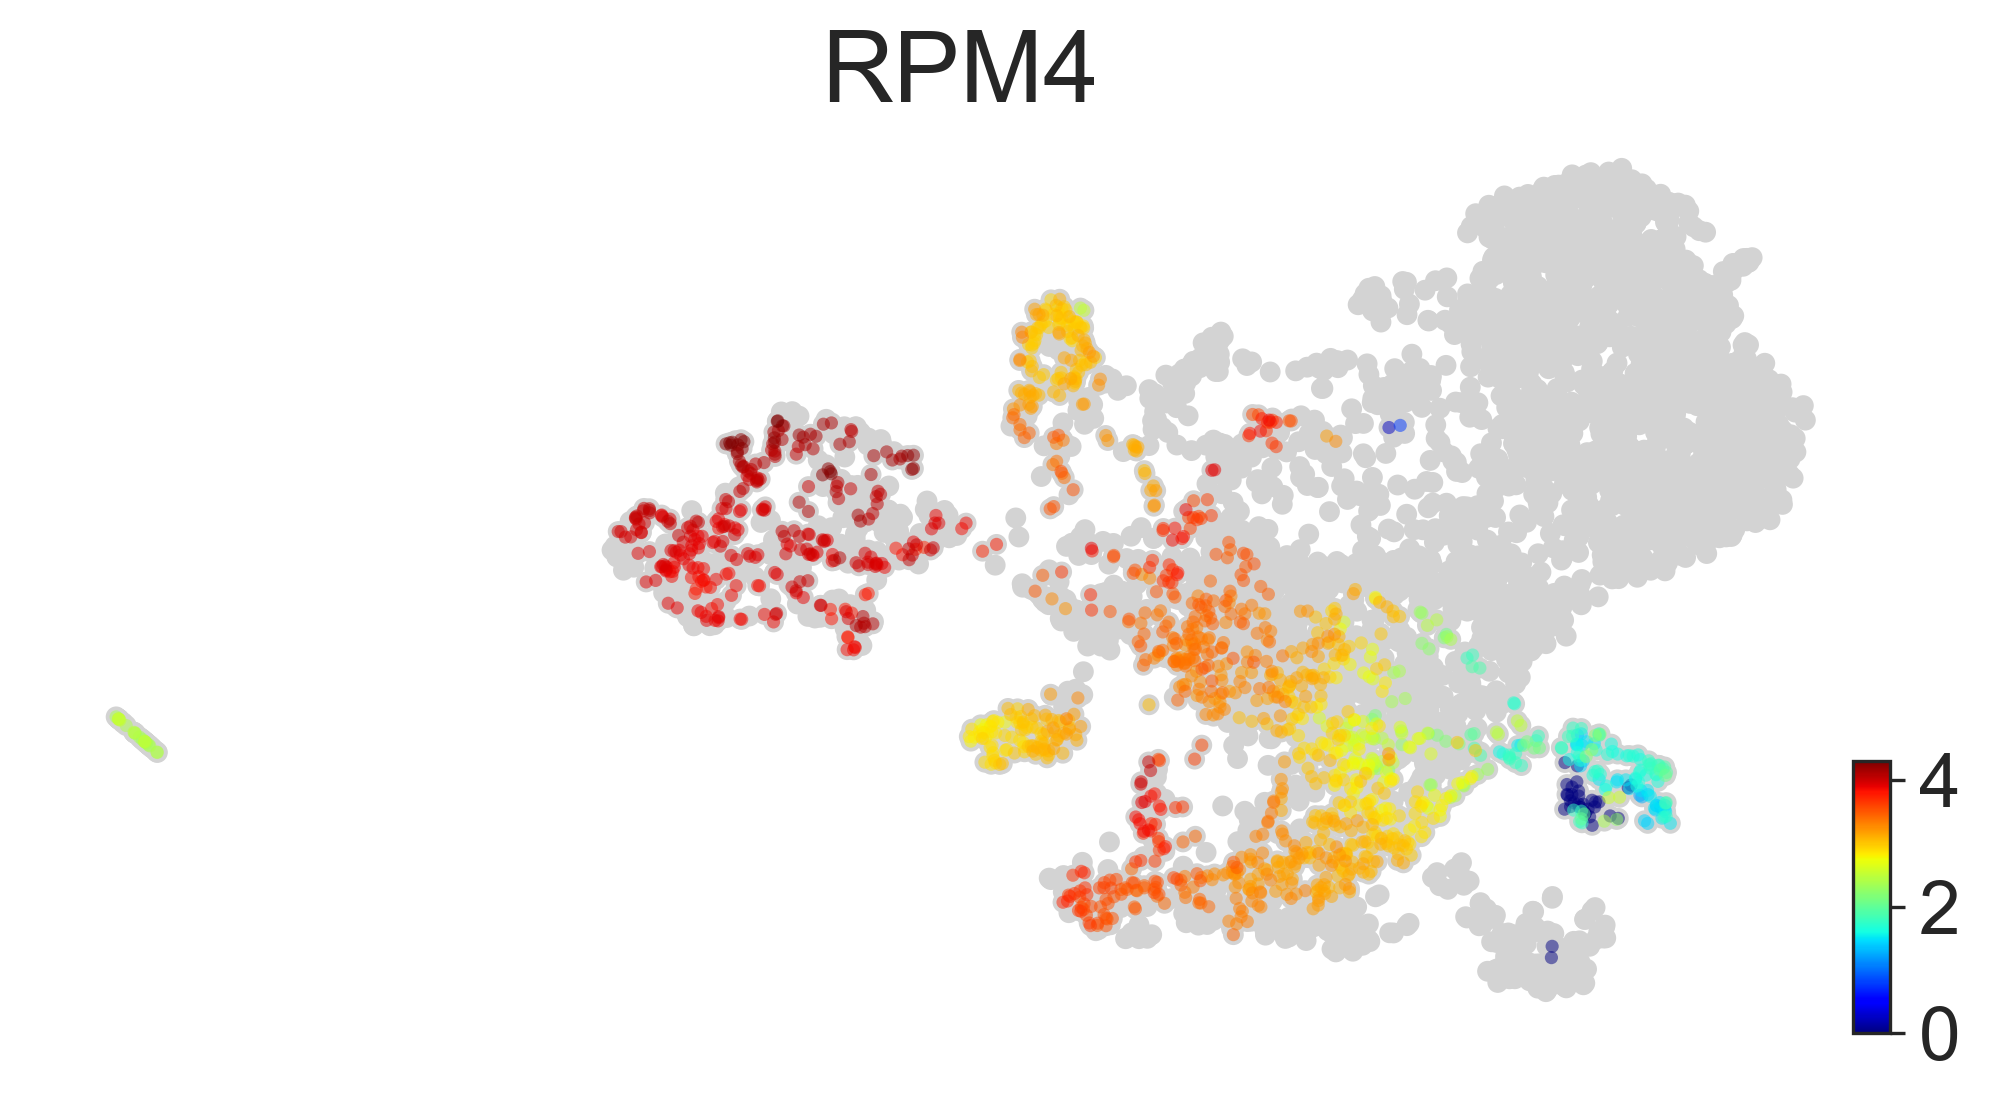

In [34]:
mb.pl.ctrp_groups(adata, groups='tumor')

In [ ]:
import seaborn as sns
from statannot import add_stat_annotation
for t in [1,2,3,4]:
    _adata = adata.copy()[adata.obs['tumor'] == f'RPM{t}']
    cp = ['#a9a9a9','#d3d3d3','#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
    df = _adata.obs[['arc_aa_type','ctrp']].pivot(columns='arc_aa_type')
    df.columns = df.columns.droplevel(0)
    sorted_index = df.median().sort_values().index
    plt.figure(figsize=(3,4))
    ax = sns.boxplot(data = _adata.obs, y='arc_aa_type',x = 'ctrp',palette=[cp[2],cp[4],cp[0],cp[3],cp[1],cp[5], cp[6]],
                    order = sorted_index)
#     add_stat_annotation(ax, data=_adata.obs, y='arc_aa_type',x = 'ctrp',
#                         order = sorted_index,
#                         box_pairs=[('SCLC-Y Specialist','Unclassified'),
#                                   ('SCLC-Y Specialist','SCLC-A Specialist'), ("SCLC-Y Specialist", "SCLC-A2 Specialist"),
#                                    ("SCLC-Y Specialist", "Generalist"),   ("SCLC-Y Specialist", "SCLC-P Specialist"),
#                                   ("SCLC-N Specialist", "SCLC-Y Specialist")],
#                         test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
    plt.savefig(f'./figures/rpm_tumors/ctrp_rpm_tumor_{t}_barplot_rotated.pdf')


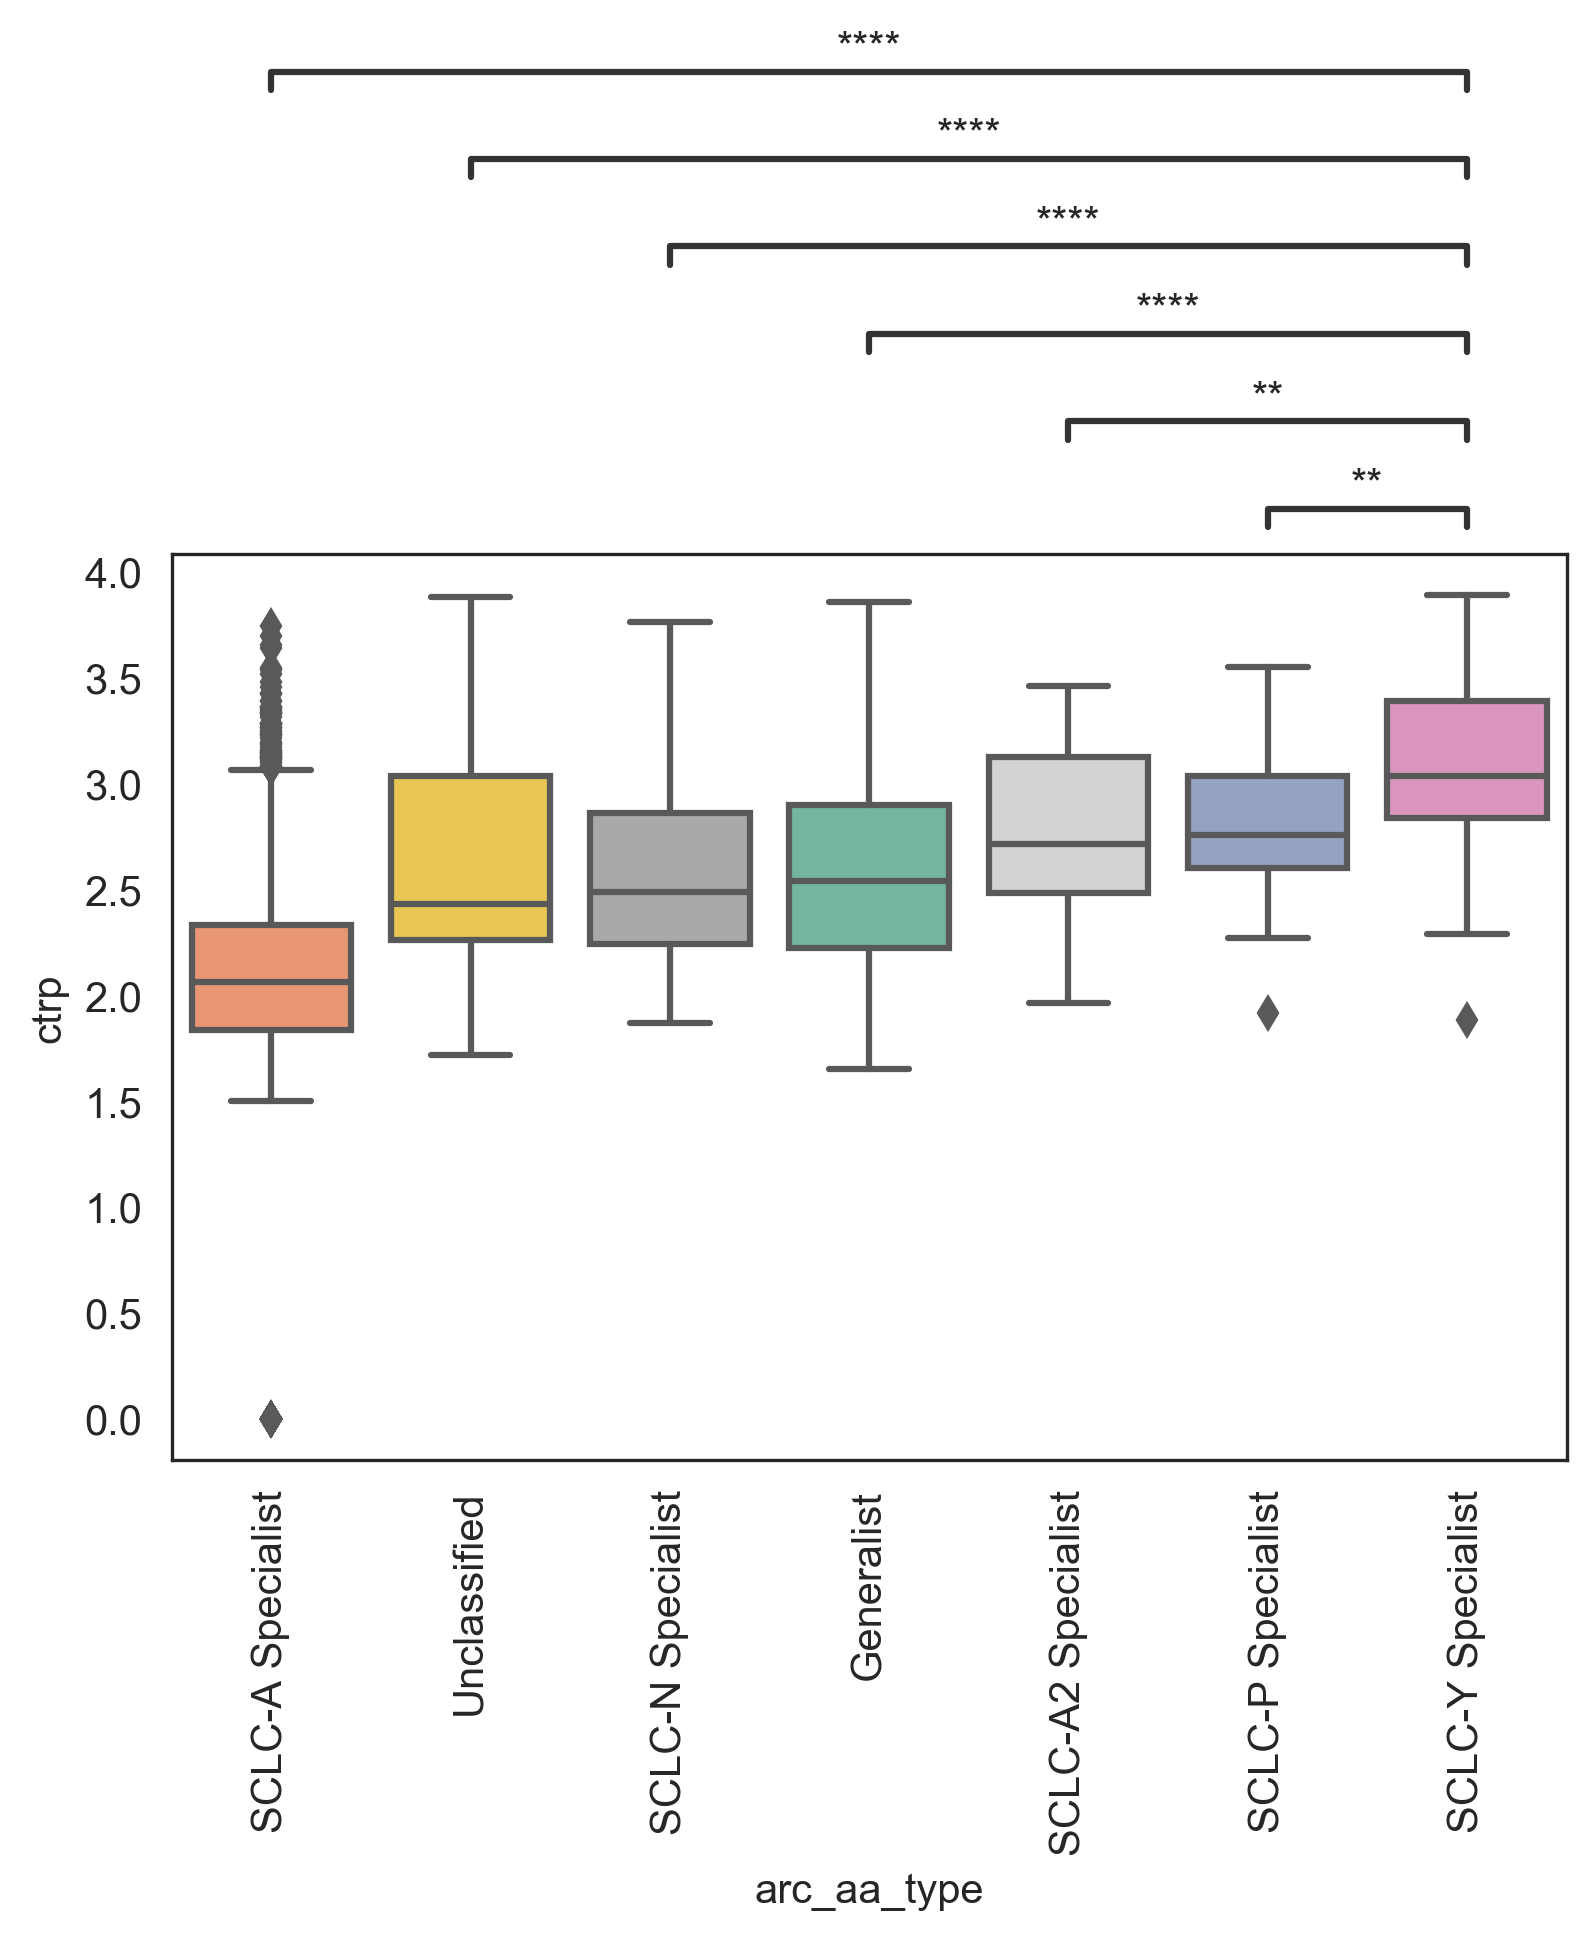

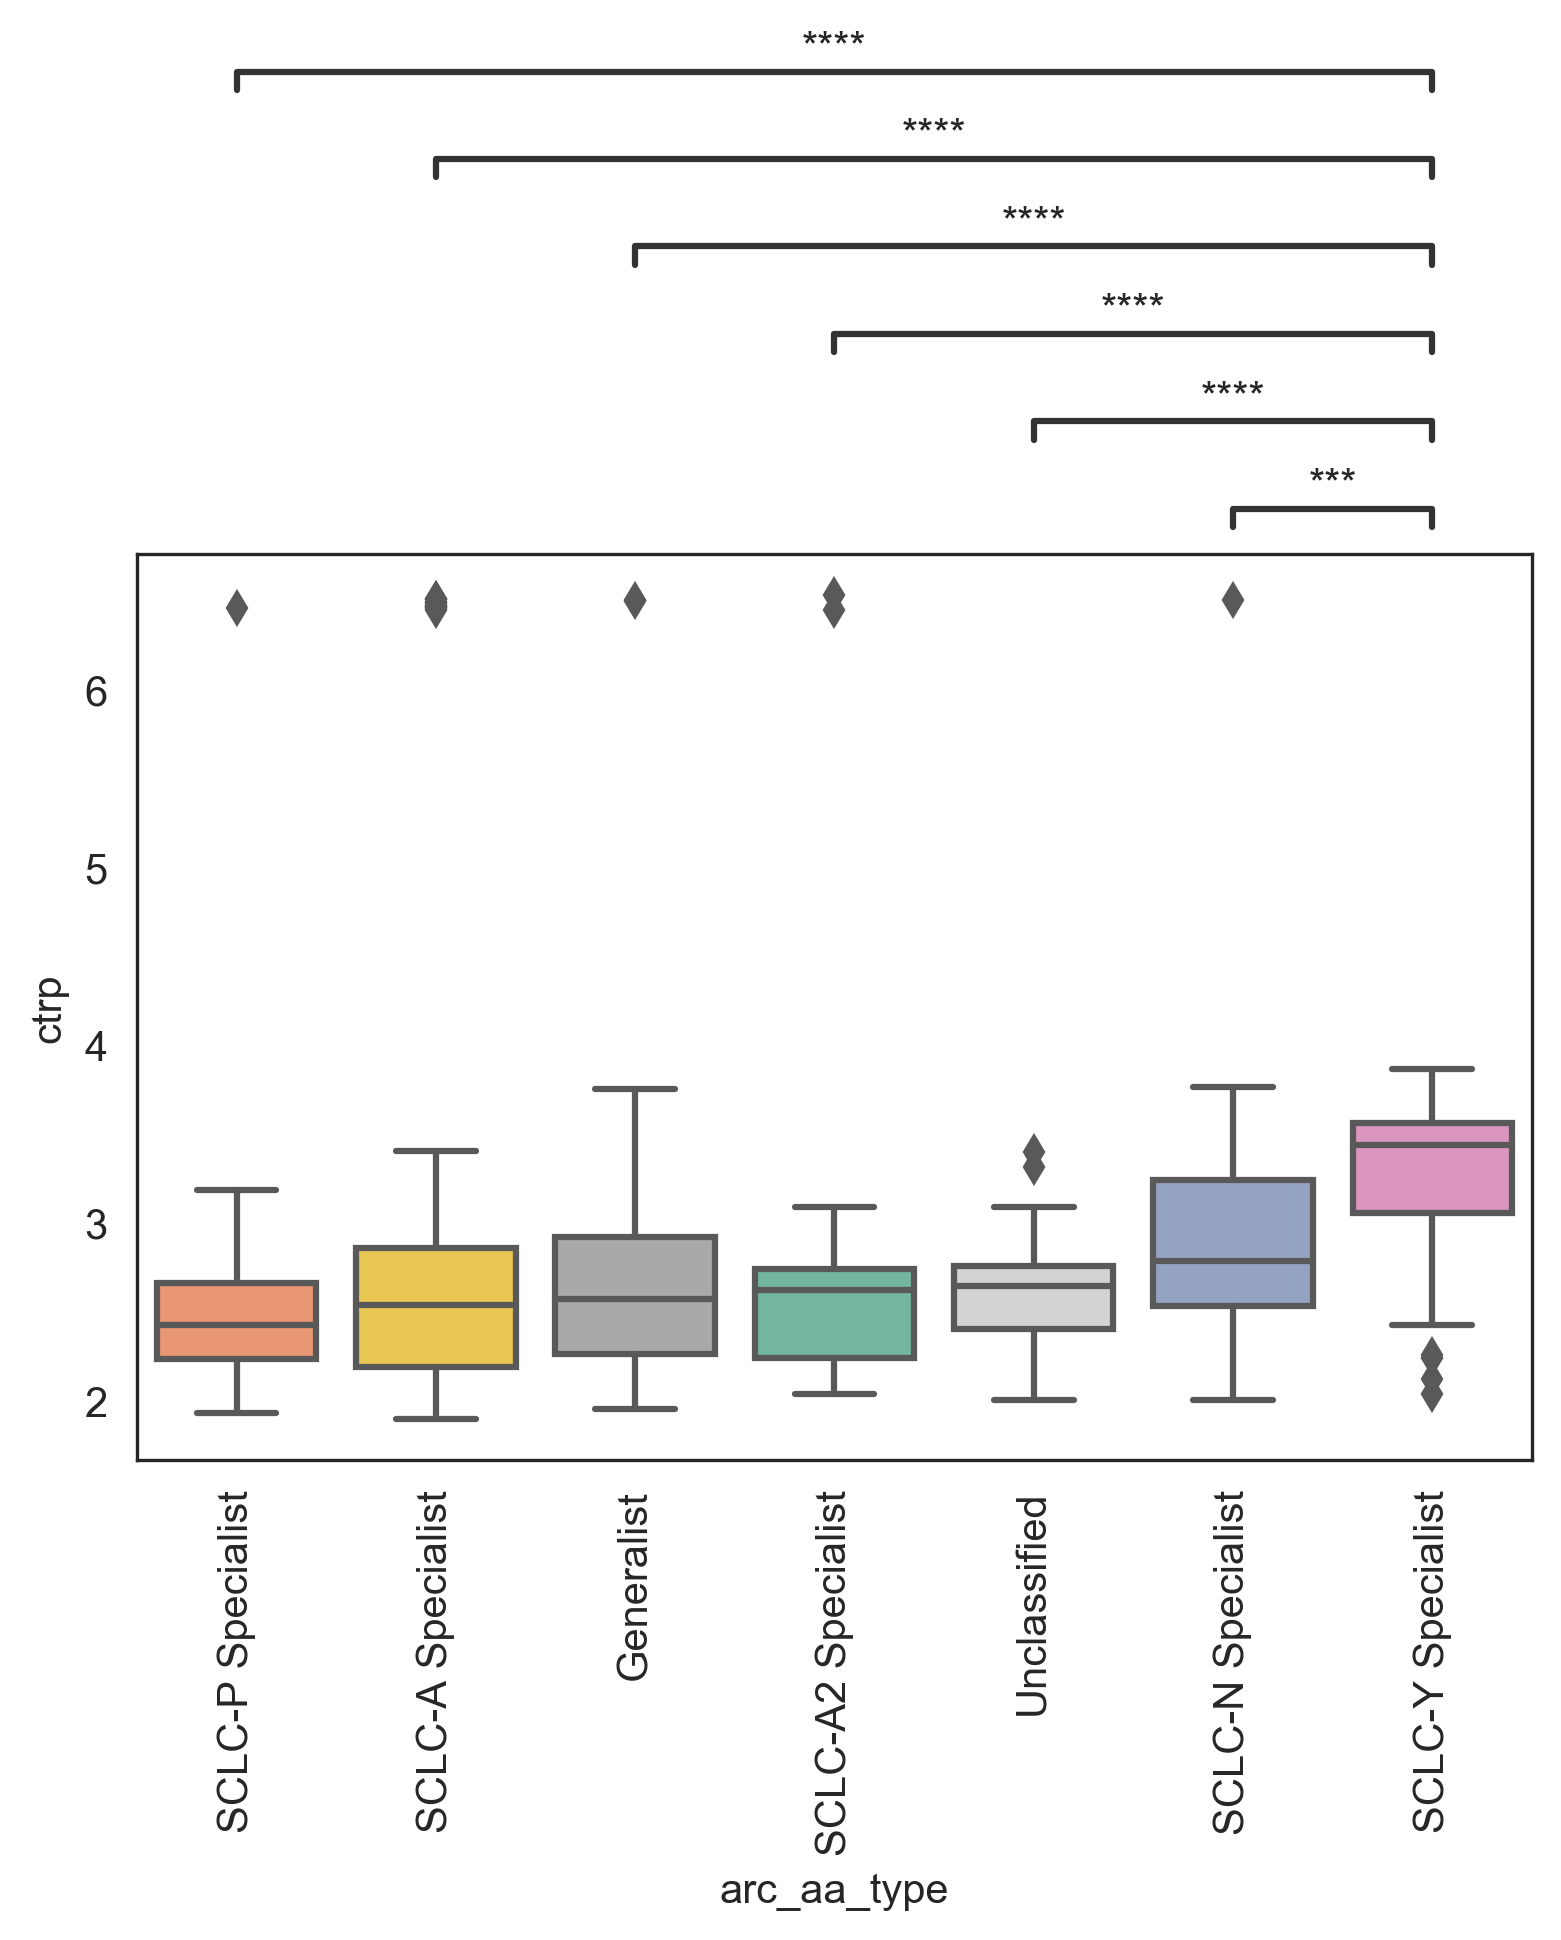

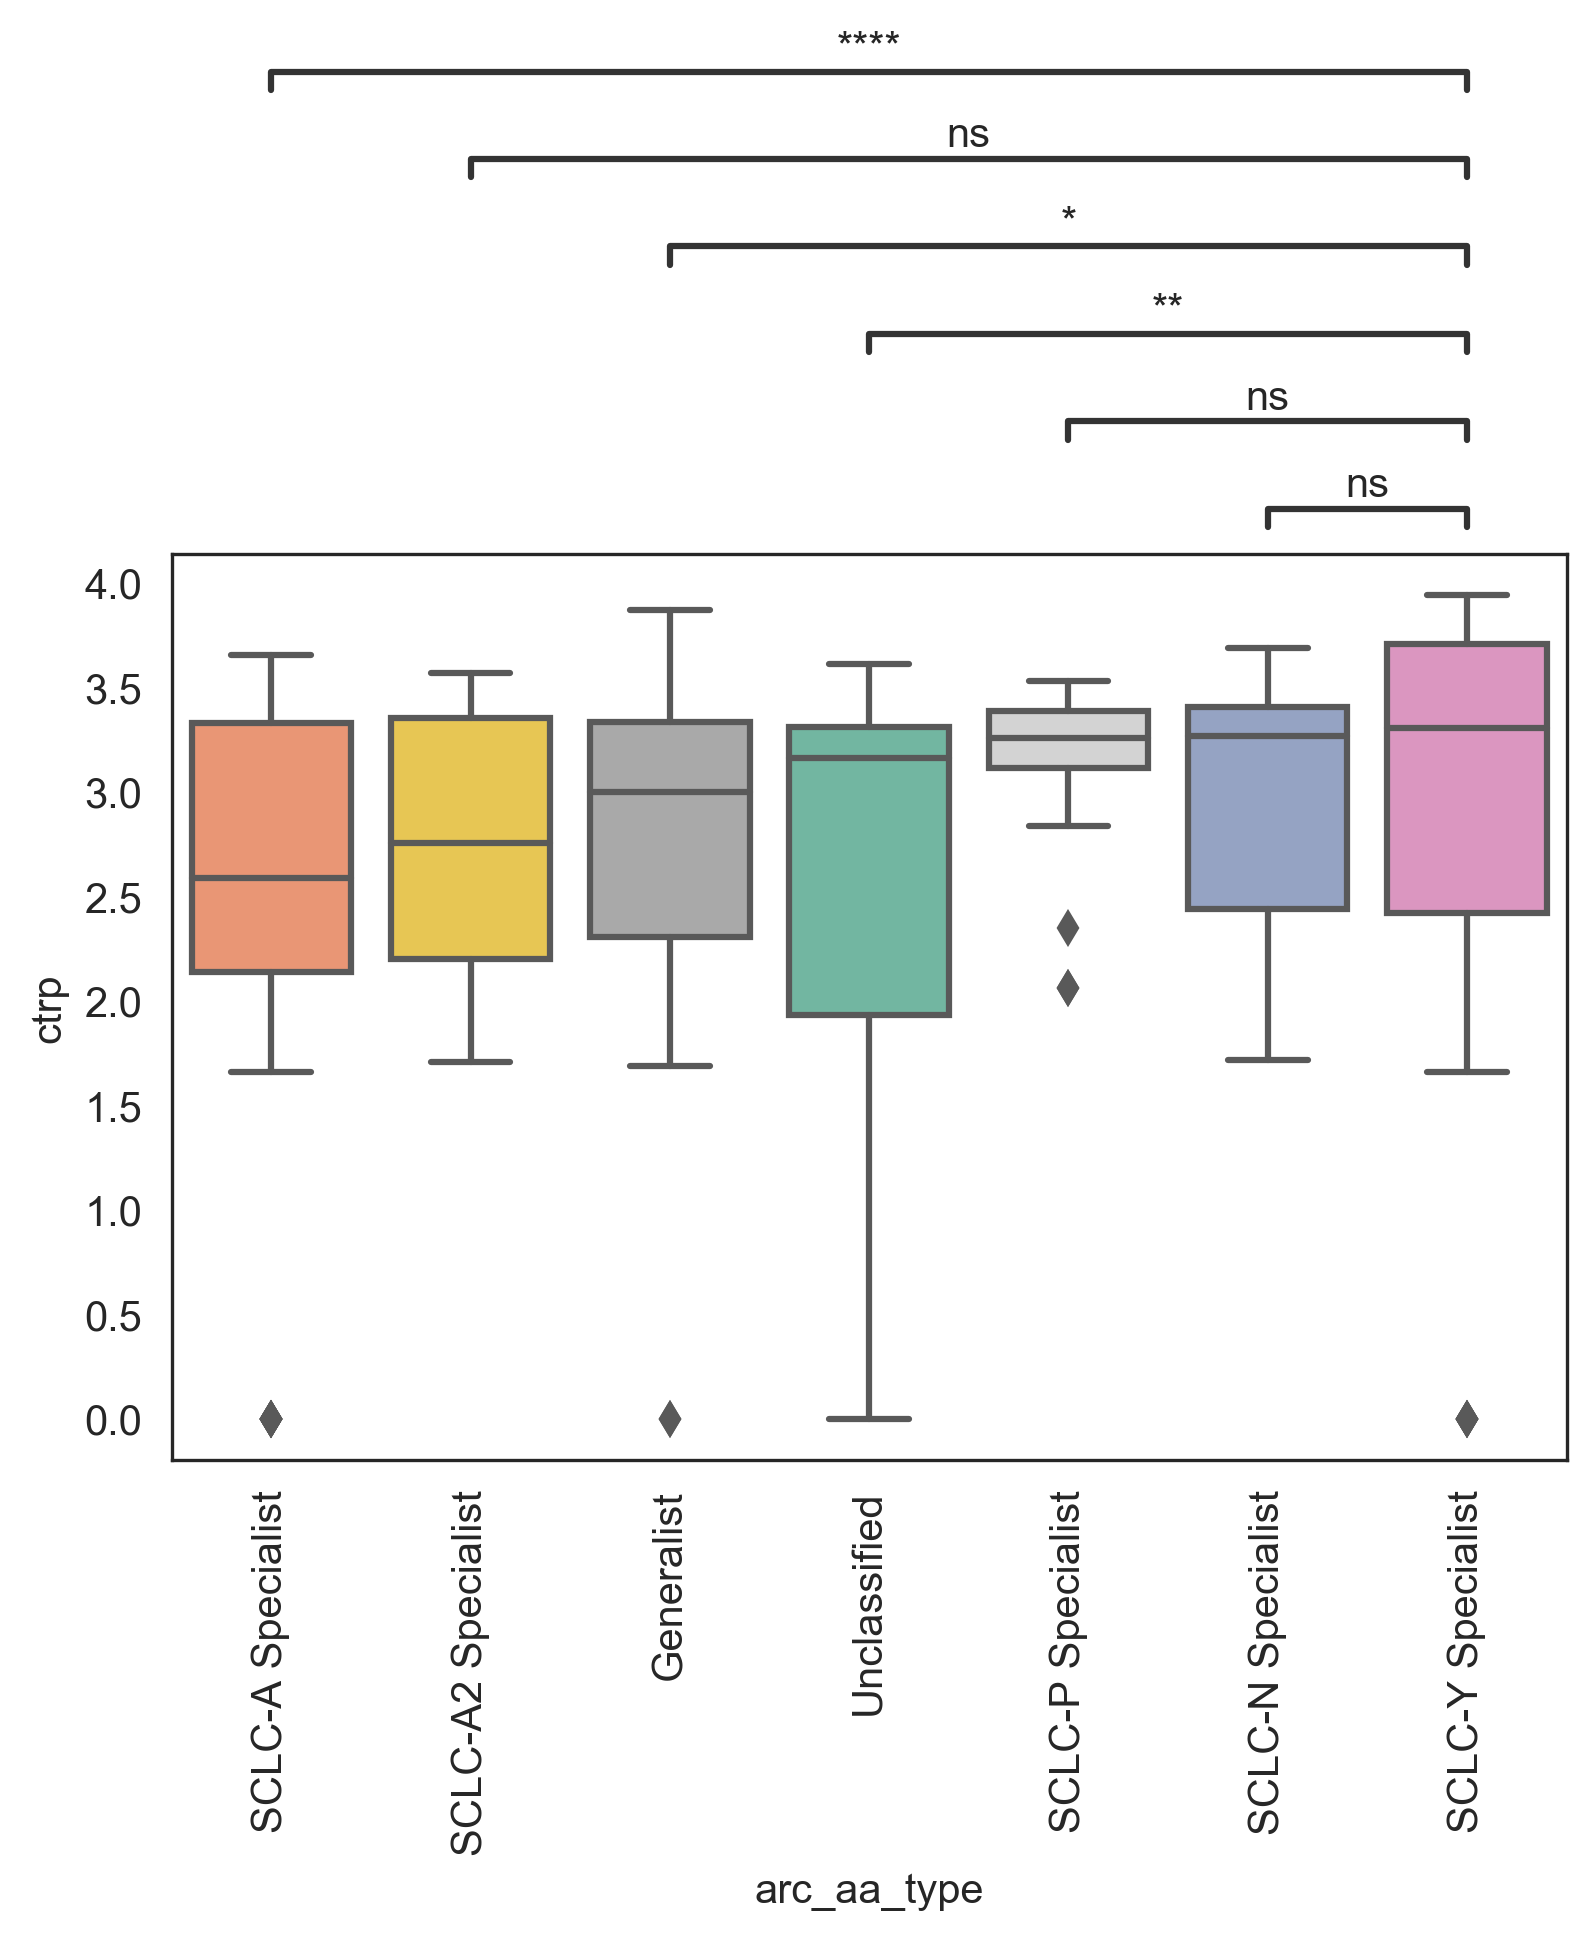

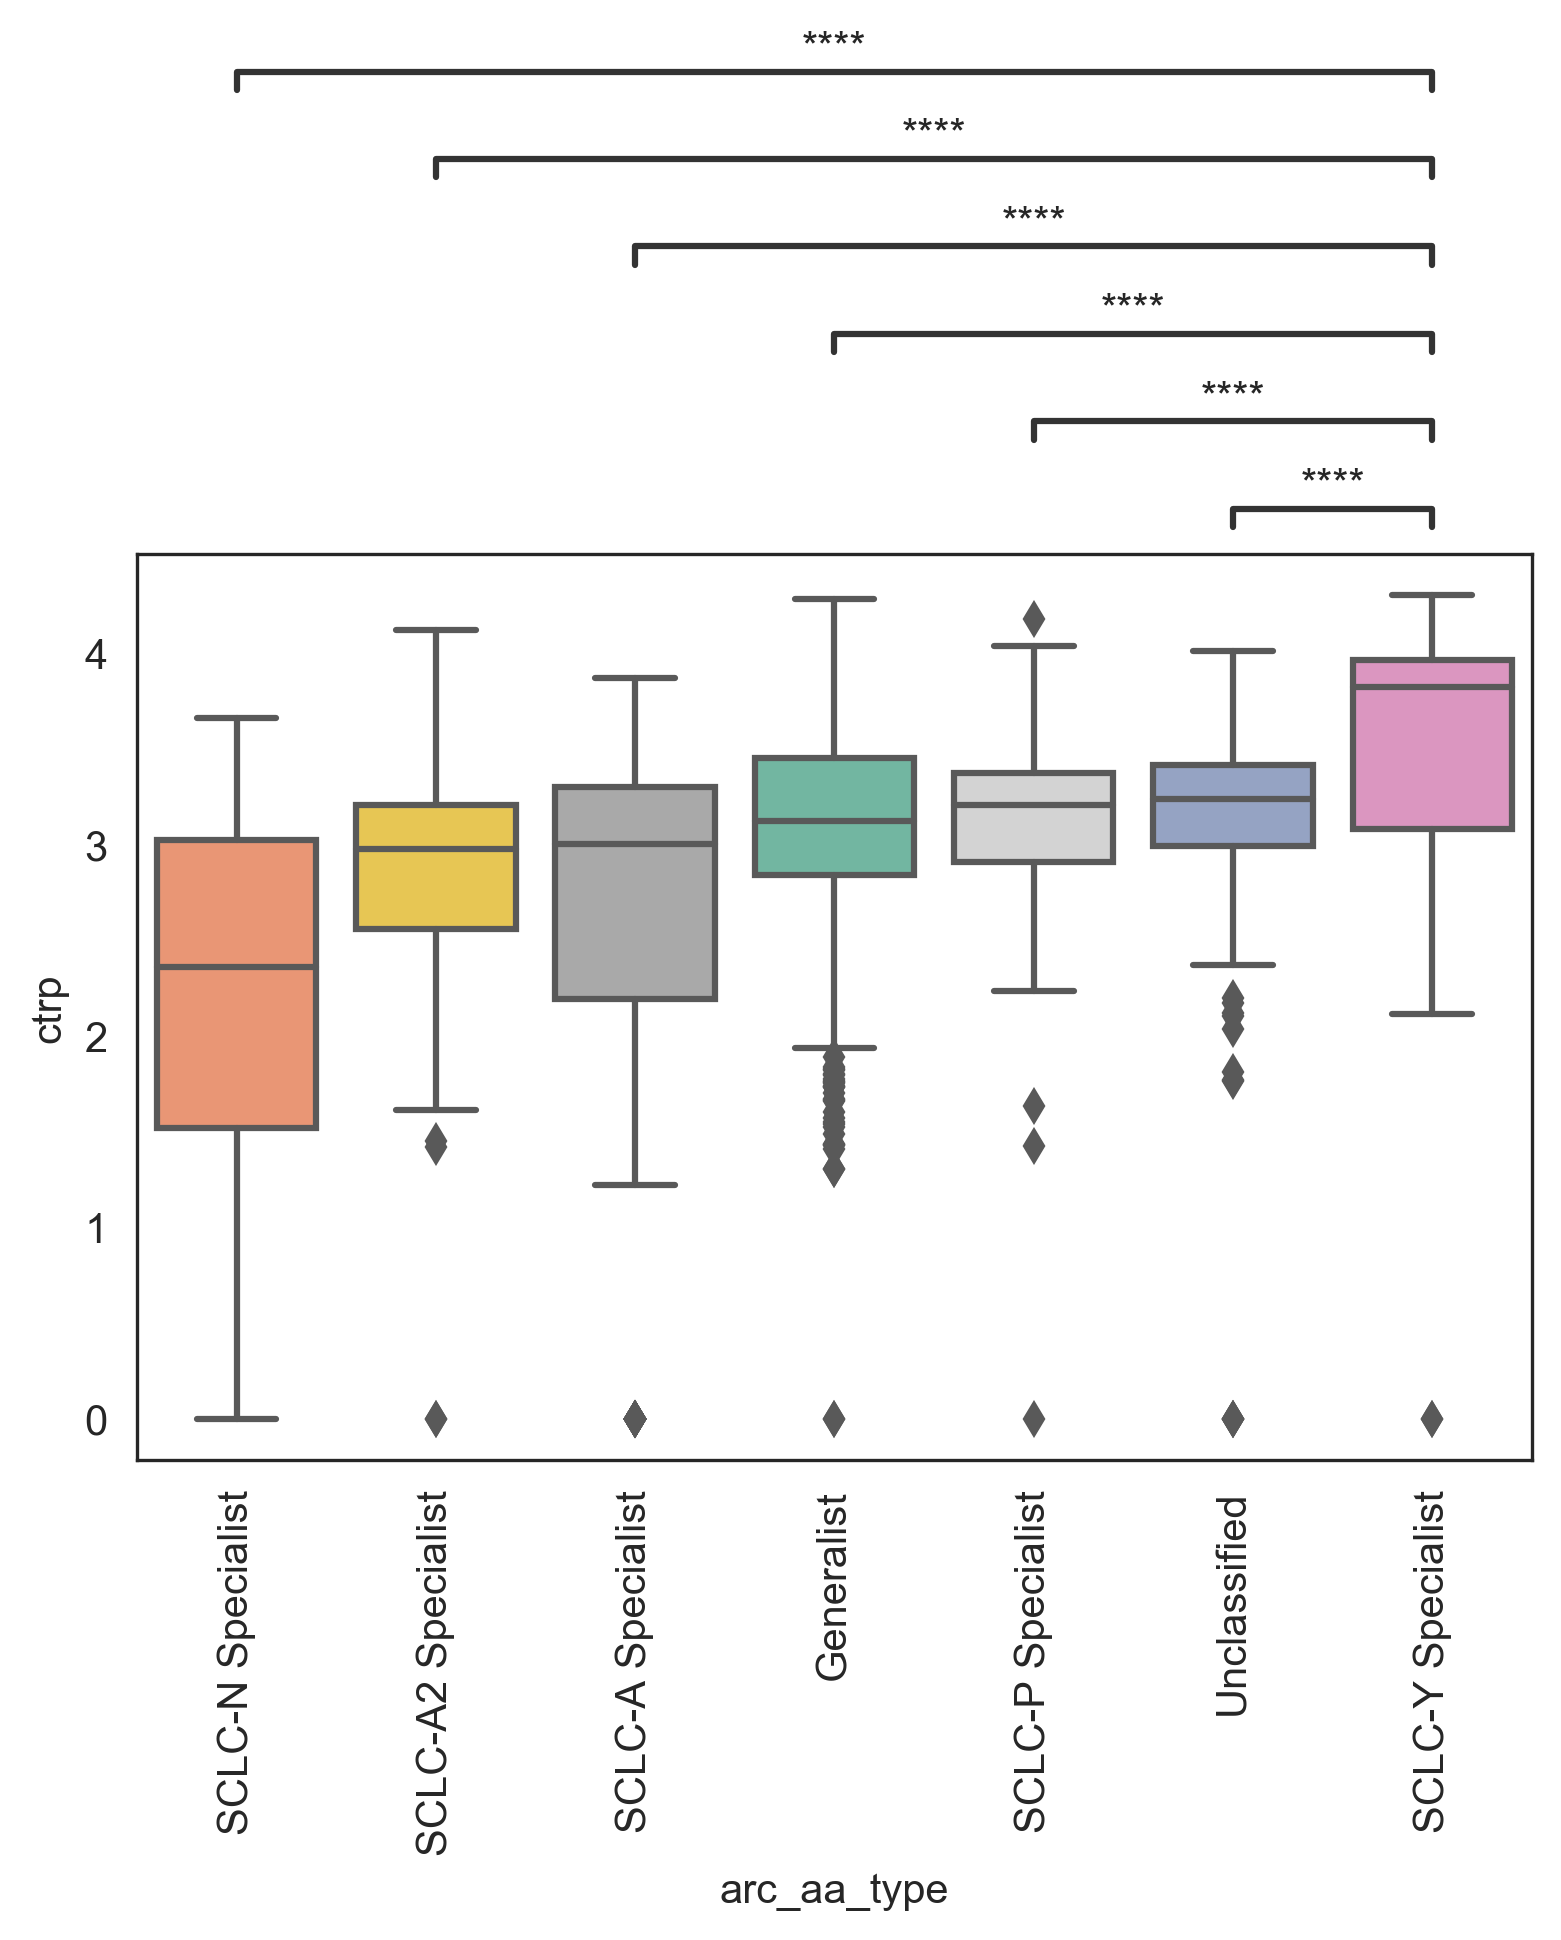

In [47]:
import seaborn as sns
from statannot import add_stat_annotation
for t in [1,2,3,4]:
    _adata = adata.copy()[adata.obs['tumor'] == f'RPM{t}']
    cp = ['#a9a9a9','#d3d3d3','#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
    df = _adata.obs[['arc_aa_type','ctrp']].pivot(columns='arc_aa_type')
    df.columns = df.columns.droplevel(0)
    sorted_index = df.median().sort_values().index
    plt.figure(figsize=(6,4))
    ax = sns.boxplot(data = _adata.obs, x='arc_aa_type',y = 'ctrp',palette=[cp[2],cp[4],cp[0],cp[3],cp[1],cp[5], cp[6]],
                    order = sorted_index)
    plt.xticks(rotation = 90)
    add_stat_annotation(ax, data=_adata.obs, x='arc_aa_type',y = 'ctrp',
                        order = sorted_index,
                        box_pairs=[('SCLC-Y Specialist','Unclassified'),
                                  ('SCLC-Y Specialist','SCLC-A Specialist'), ("SCLC-Y Specialist", "SCLC-A2 Specialist"),
                                   ("SCLC-Y Specialist", "Generalist"),   ("SCLC-Y Specialist", "SCLC-P Specialist"),
                                  ("SCLC-N Specialist", "SCLC-Y Specialist")],
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
#     plt.savefig(f'./figures/rpm_tumors/ctrp_rpm_tumor_{t}_barplot.pdf')


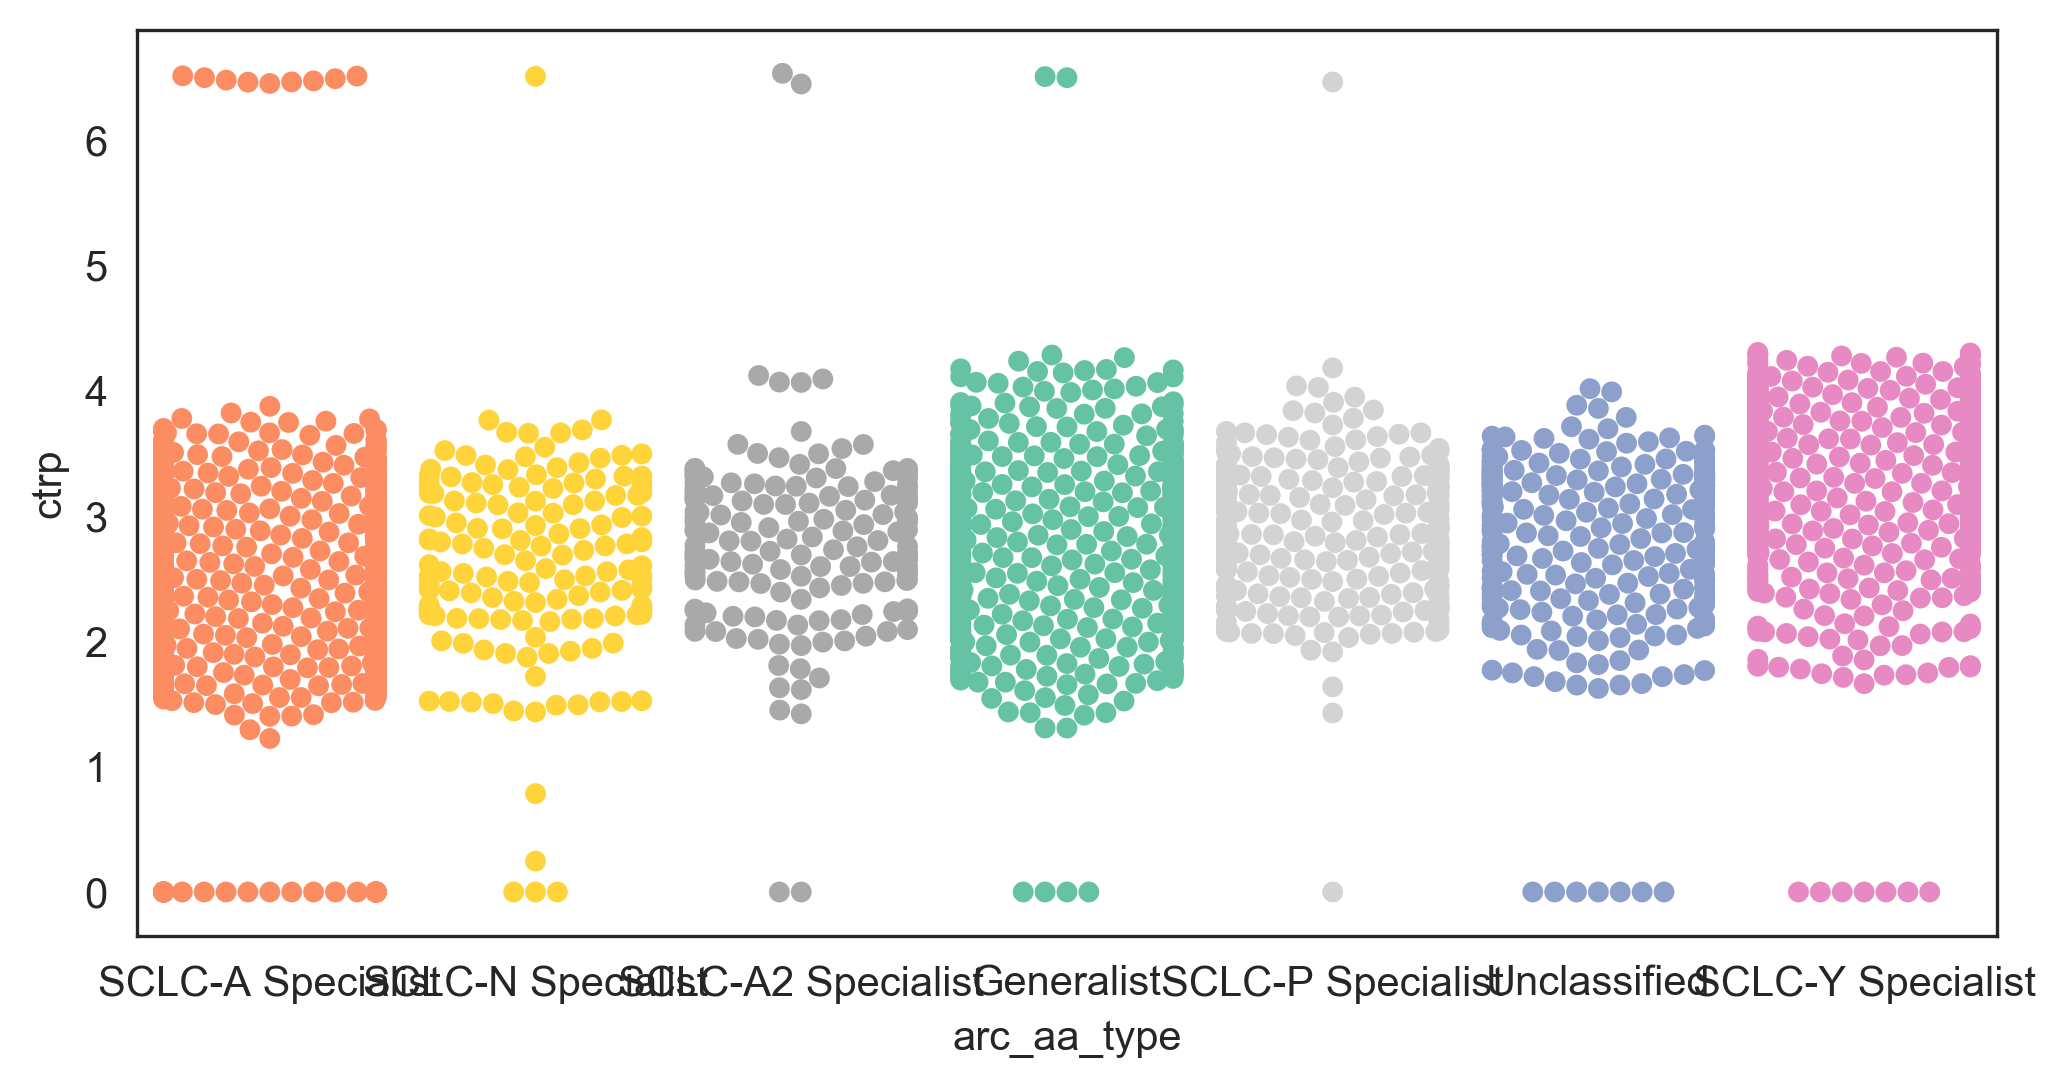

In [37]:
sns.swarmplot(data = adata.obs, x='arc_aa_type',y = 'ctrp',palette=[cp[2],cp[4],cp[0],cp[3],cp[1],cp[5], cp[6]],
                order = sorted_index)

In [35]:
adata.obs['absorbing']

SRR11594447:AACAACCCAATACCCAx-RPM1      False
SRR11594447:AAACGCTCACAGTATCx-RPM1       True
SRR11594447:AAAGTGAAGAGATCGCx-RPM1      False
SRR11594447:AACAAAGCAAAGGAGAx-RPM1      False
SRR11594447:AACACACTCGTAGCTAx-RPM1      False
                                        ...  
SRR11594452:TTTGATCCAGACGCTCx-1-RPM4    False
SRR11594452:TTTGTTGGTCTTGCTCx-1-RPM4    False
SRR11594452:TTTGACTAGAGCATCGx-1-RPM4    False
SRR11594452:TTTGTTGGTTGCCGCAx-1-RPM4    False
SRR11594452:TTTGGTTCATCTTTCAx-1-RPM4    False
Name: absorbing, Length: 4786, dtype: category
Categories (2, object): [False, True]

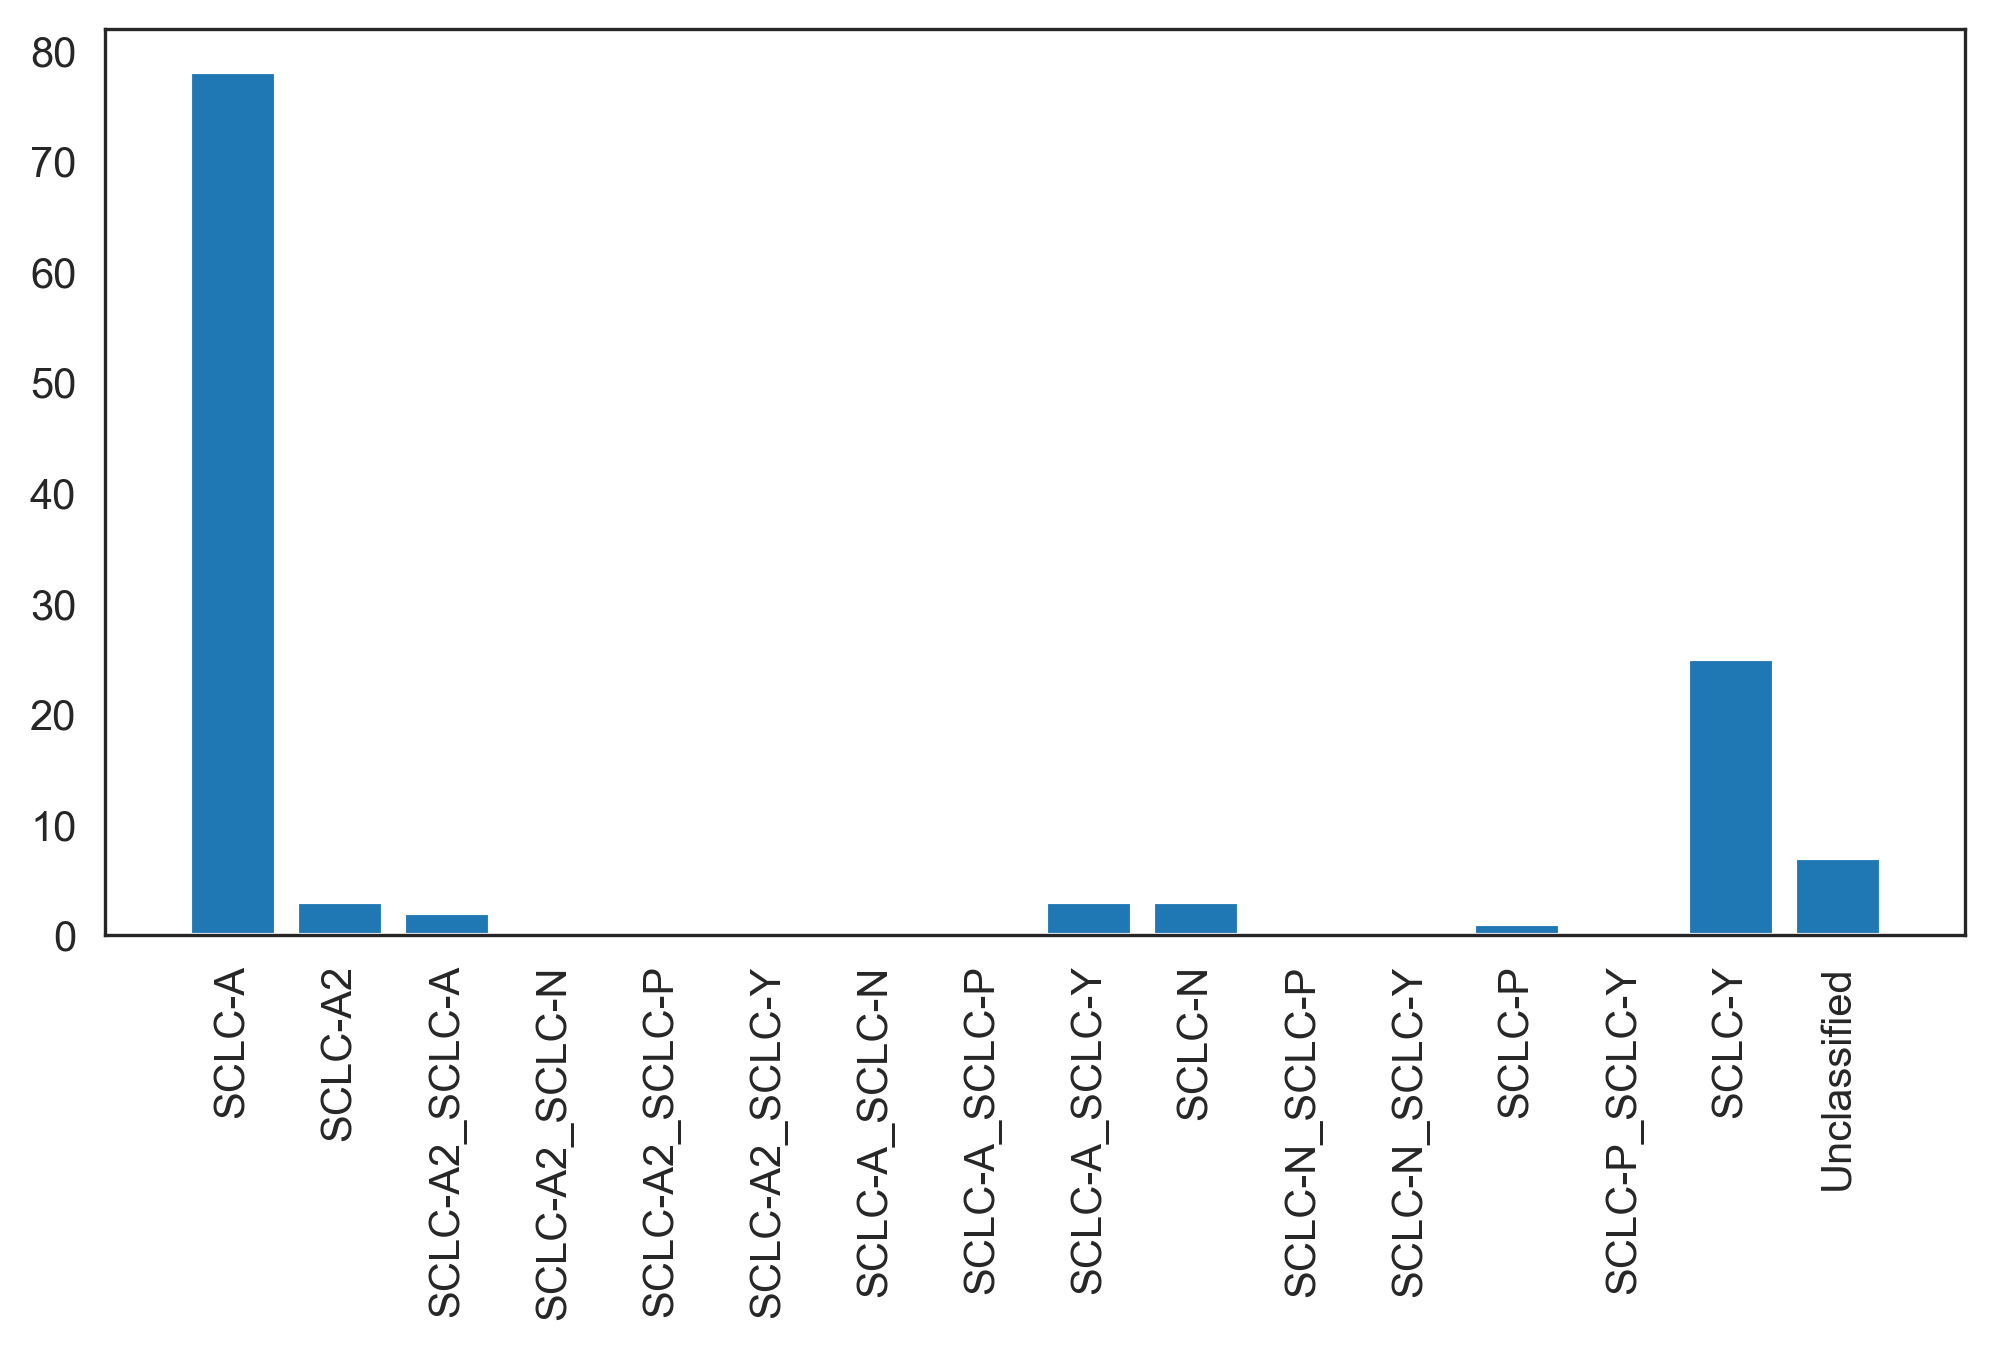

In [29]:
# f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize = (6,4))

# plot the same data on both axes
plt.bar(pd.crosstab(adata.obs['arc_pheno'], adata.obs['absorbing']).index, 
       pd.crosstab(adata.obs['arc_pheno'], adata.obs['absorbing'])['True'])
plt.xticks(rotation = 90)

# ax2.bar(pd.crosstab(adata_small.obs['Phenotype'], adata_small.obs['absorbing']).index, 
#        pd.crosstab(adata_small.obs['Phenotype'], adata_small.obs['absorbing'])['True'])
# zoom-in / limit the view to different portions of the data
# ax.set_ylim(0, 100)  # outliers only
# # ax2.set_ylim(0, 100)  # most of the data

# # hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# # ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()
plt.savefig('./figures/rpm_tumors/absorbing_rpm_arc_pheno.pdf')

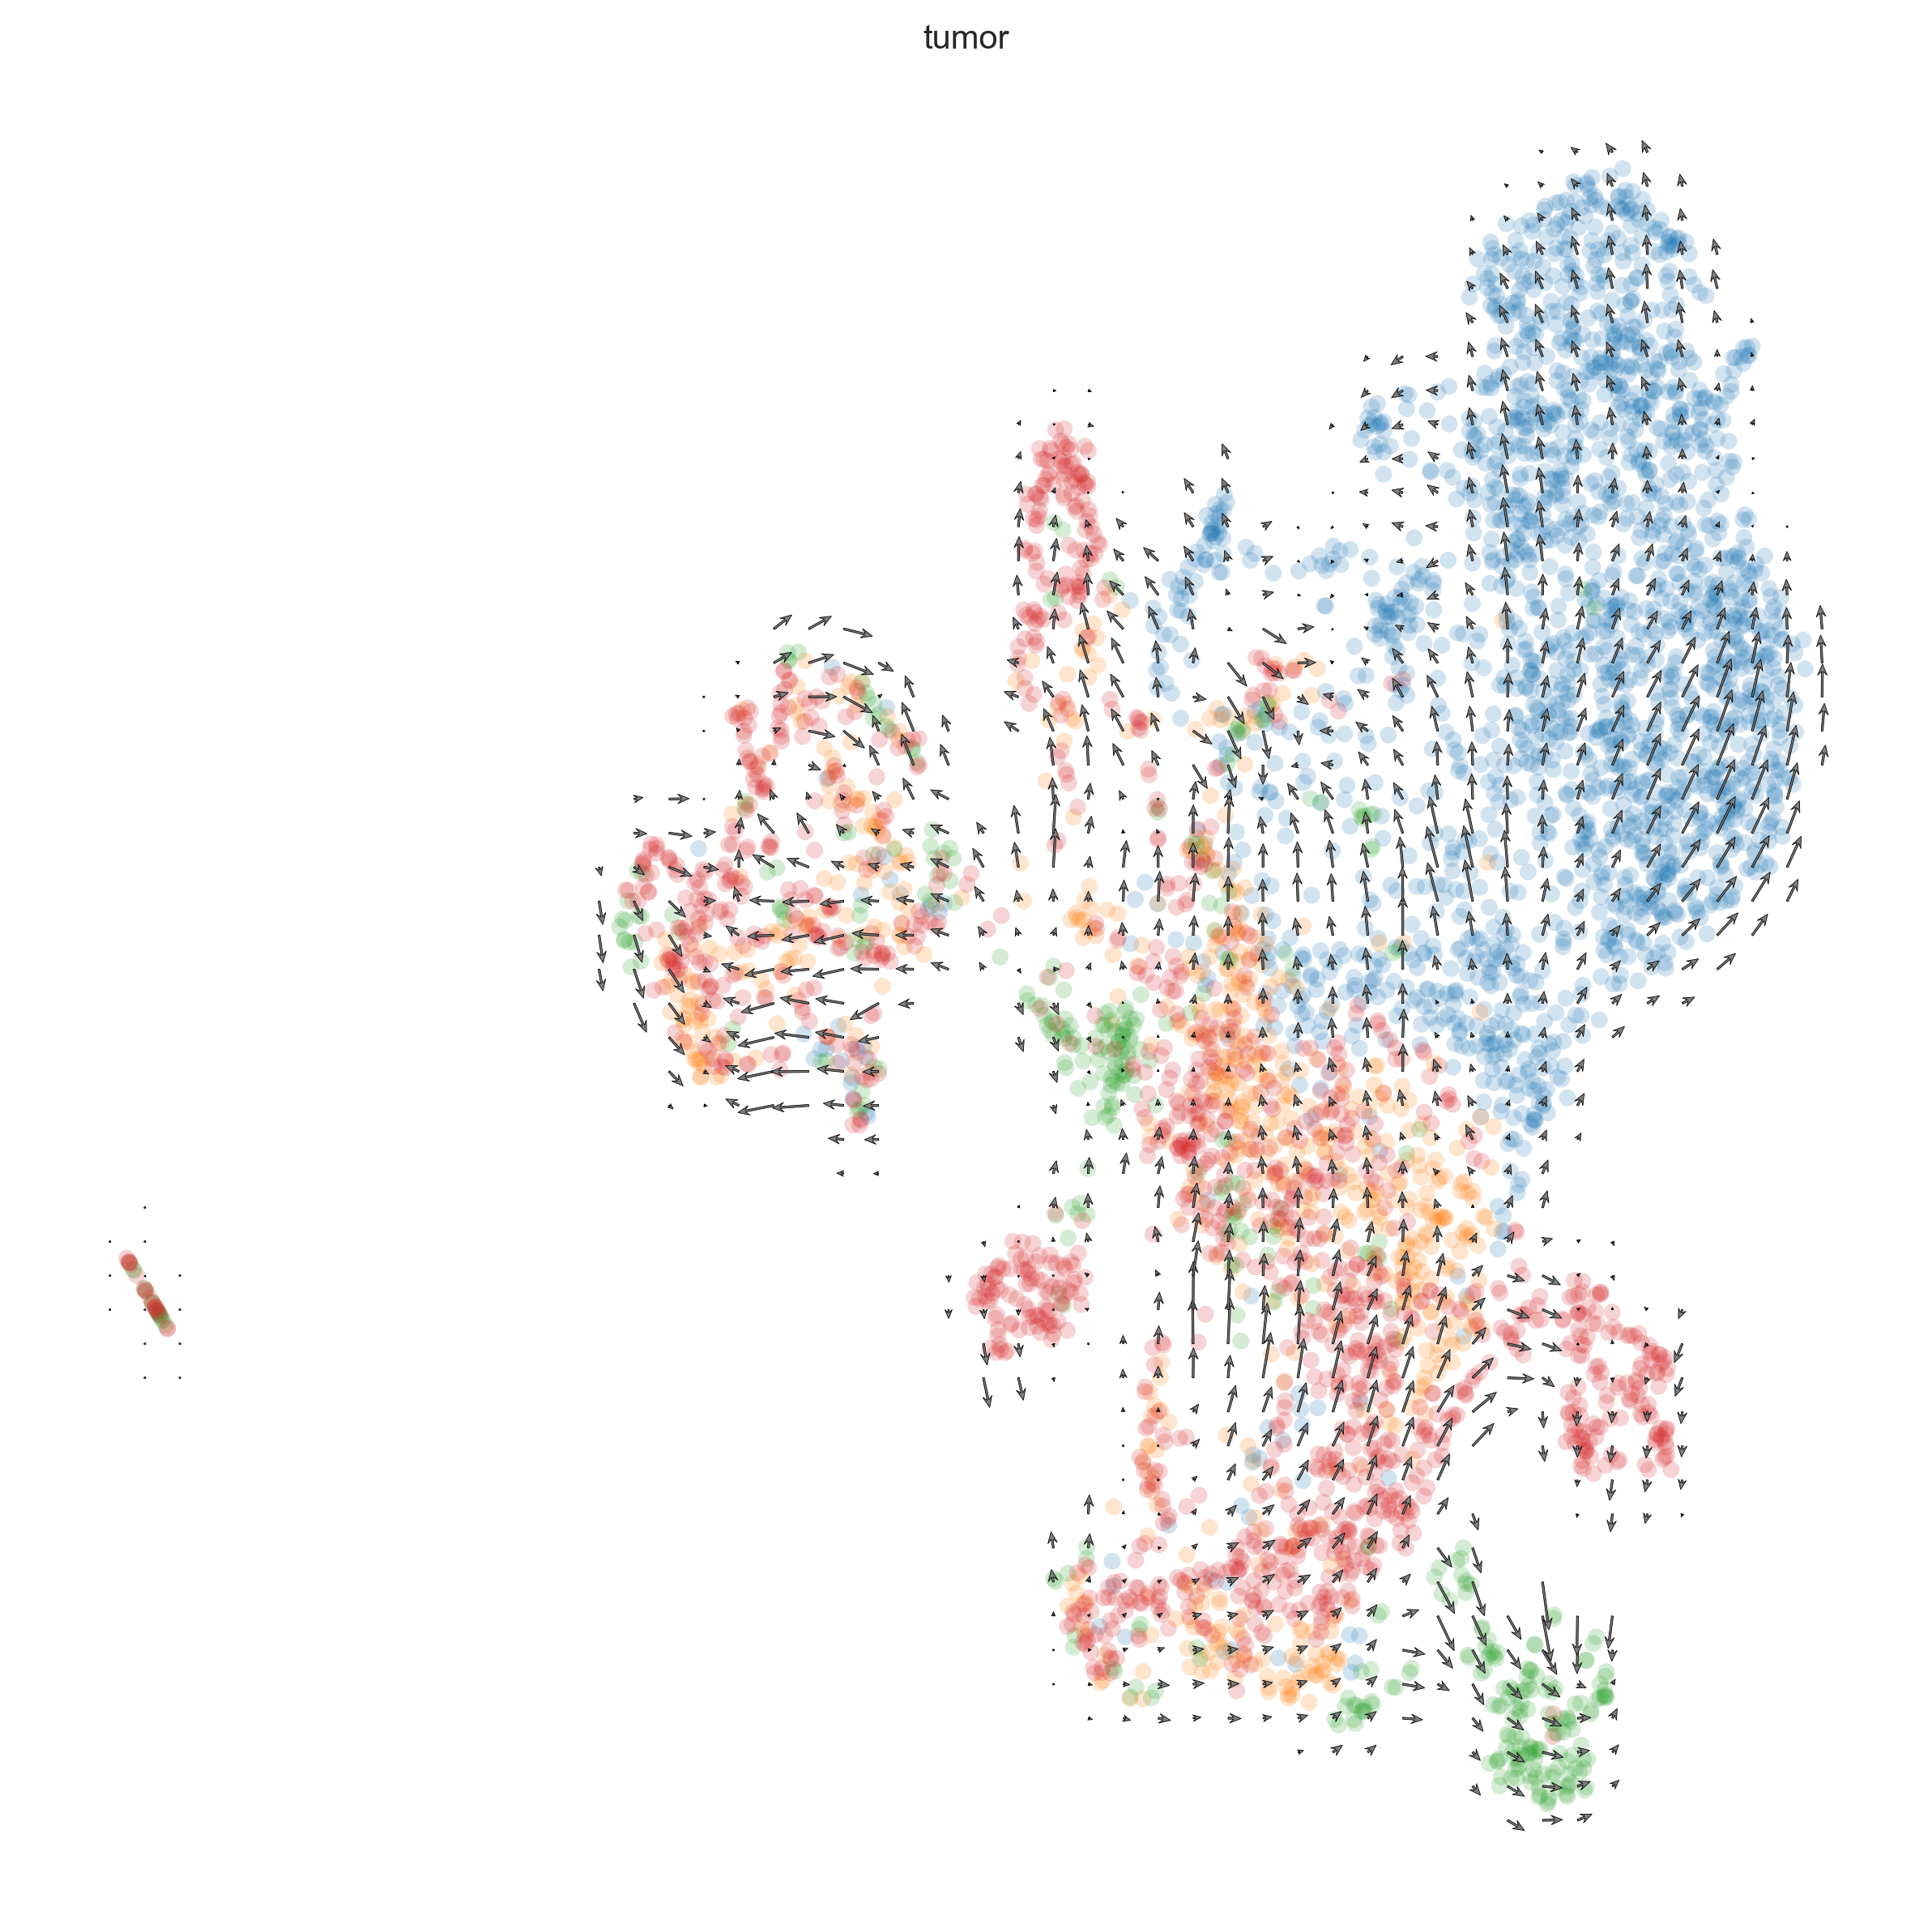

In [36]:
scv.pl.velocity_embedding_grid(adata, color = 'tumor', figsize =(10,10))

## Additional analyses

## Doublets

In [48]:
mb.pp.doublet_detections(adata, layer = 'matrix')

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 5.2 seconds


In [49]:
adata.obs.groupby('arc_aa_type').sum()['predicted_doublets']

arc_aa_type
Generalist            0
SCLC-A Specialist     0
SCLC-A2 Specialist    0
SCLC-N Specialist     0
SCLC-P Specialist     0
SCLC-Y Specialist     0
Unclassified          0
Name: predicted_doublets, dtype: int64

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 4.2 seconds


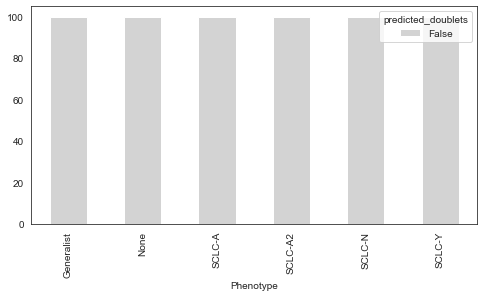

In [339]:
# mb.pp.doublet_detections(adata, layer='matrix')
# adata_small.obs['doublet_scores'] = adata.obs['doublet_scores']
# adata_small.obs['predicted_doublets'] = adata.obs['predicted_doublets']
# adata_small.obs['doublet_scores'] = adata.obs['doublet_scores']
# adata_small.obs['predicted_doublets'] = adata.obs['predicted_doublets']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(adata_small.obs['predicted_doublets'], adata_small.obs['Phenotype'])/
  pd.crosstab(adata_small.obs['predicted_doublets'], adata_small.obs['Phenotype']).sum(axis = 0))*100).T.plot.bar(stacked = True,color = ['#d3d3d3','black'])
plt.savefig('./figures/rpm_doublets.pdf')

In [340]:
adata.write_h5ad('../int/rpm/adata05_tumor.h5ad')

In [2]:
adata = sc.read_h5ad('../int/rpm/adata05_tumor.h5ad')

In [3]:
# fmt: off
s_genes_list = \
    ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']

g2m_genes_list = \
    ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']


In [4]:
scv.tl.score_genes_cell_cycle(adata, s_genes=s_genes_list, g2m_genes=g2m_genes_list)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Index(['SCLC-A_Score', 'SCLC-Y_Score', 'SCLC-N_Score'], dtype='object')


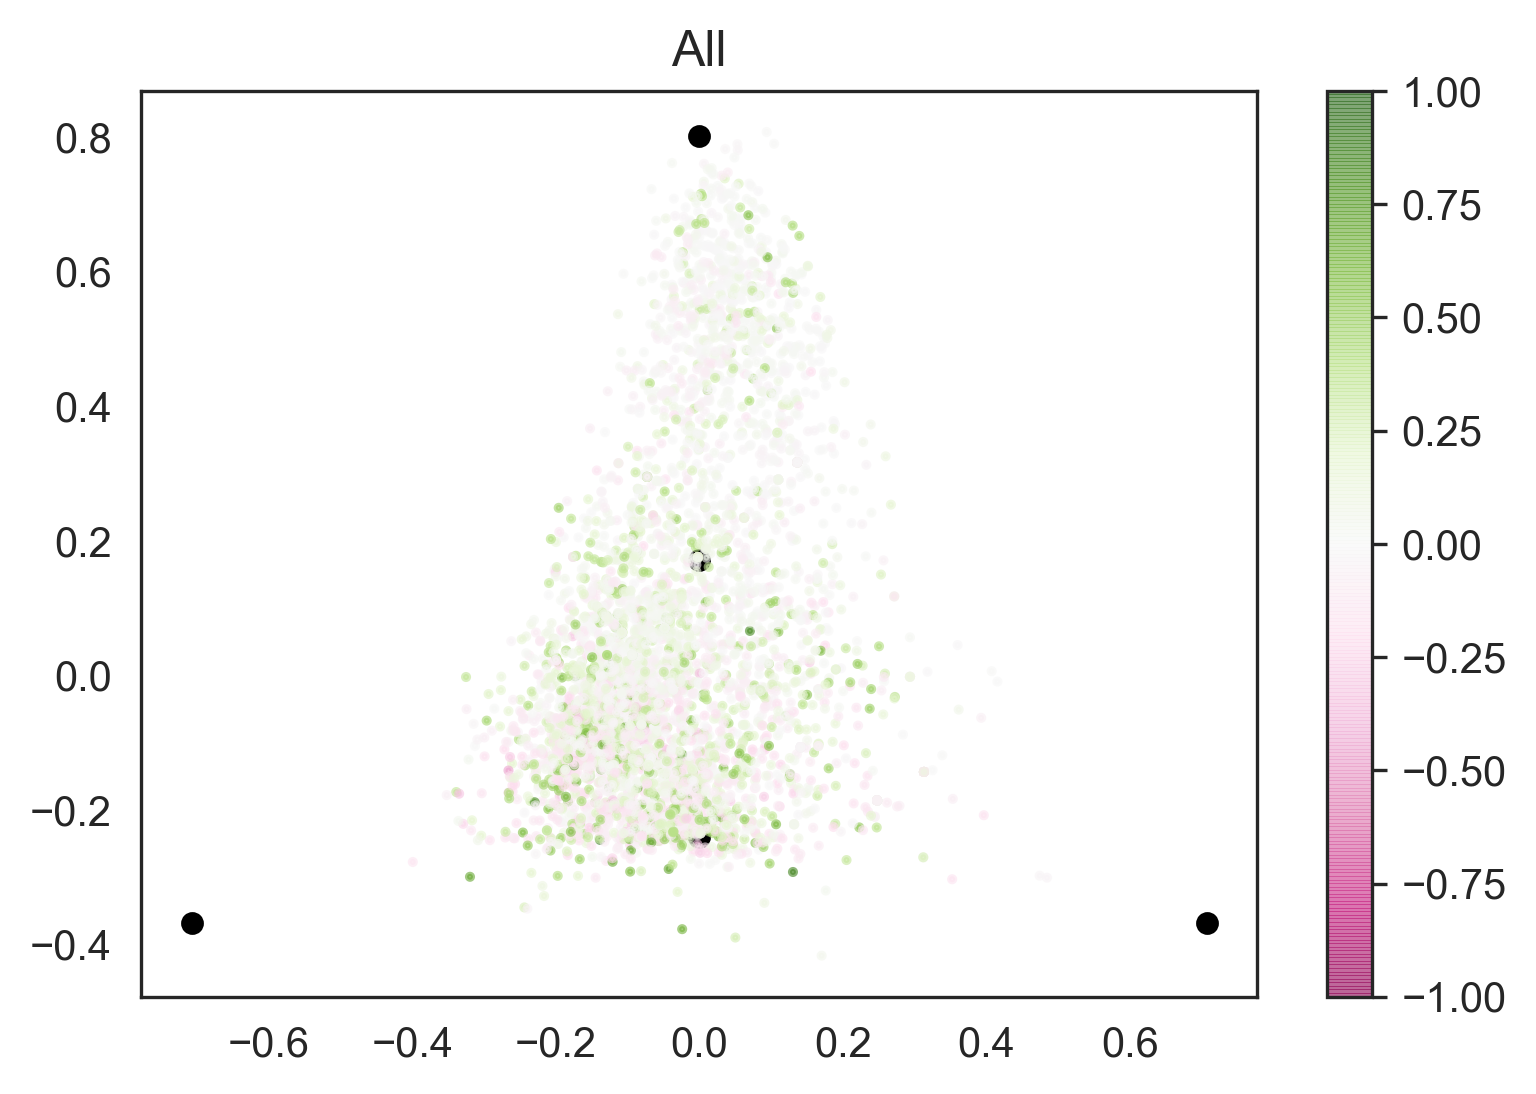

In [15]:
 import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
adata_small.obs['phase_score'] = adata.obs['G2M_score'] - adata.obs['S_score']
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y': cp[4], 'SCLC-A': cp[0], 'SCLC-A2': cp[1], 'SCLC-N': cp[2], 'SCLC-P': cp[3],
              'Generalist': 'darkgray', 'None': 'lightgrey'}
mb.pl.archetype_diagrams(adata_small, sig_matrix, color_dict=color_dict, groupby='None',color='phase_score',grid = False,
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',num_steps = 40,cmap = 'PiYG',
                        multiplier=1, figsize=(6,4), score_name = '_Score', alpha = .6, s = 2, sizes = 20, vmin = -1)